# Franchir les frontières académiques : analyse des flux de mobilité des étudiants entrant dans l'enseignement supérieur

Ce projet a été réalisé dans le cadre du cours de 2ème année de l'ENSAE "Python pour la data science" par Mathieu CAMBON, Charlotte HIECQUE et Elise MENSCH. 

## Sommaire
1. [Introduction](#intro)
2. [Préparation des données](#donnees)
3. [Statistiques descriptives](#statsdesc)
    - [Disparités géographiques](#geo)
    - [Excellence](#excellence)
    - [Sélectivité](#selectivite)
    - [Clivage public/privé](#public_prive)
    - [Genre](#genre)

4. [Modélisation](#modelisation)
    - [Excellence](#leffet-de-lexcellence)
    - [Sélectivité](#leffet-de-la-sélectivité)
    - [Clivage public/privé](#leffet-dêtre-une-formation-privée)
    - [Genre](#leffet-du-genre)
    - [Effet du lieu où se situe la formation](#leffet-du-lieu-où-se-situe-la-formation)
5. [Conclusion](#conclu)

<a id="intro"></a>
## Introduction

### Contexte
La plateforme Parcoursup affecte chaque année des milliers d'étudiants à une formation. Les formations sont nombreuses, et même si certaines ont le même objectif, chacune possède une identité propre pouvant inciter un étudiant à postuler à une formation plutôt qu'une autre, engendrant ainsi une certaine mobilité des étudiants. Pourtant, cette mobilité peut être contrainte par de nombreux facteurs. De plus, elle est inégalement répartie sur le territoire, avec certaines villes qui attirent un grand nombre de personnes tandis que d'autres engendrent une fuite des étudiants, qui se dirigent vers d'autres académies dans le cadre de leurs études supérieures. Il apparaît donc intéressant d'étudier la mobilité des étudiants lors de leur entrée en étude supérieure. Analyse de Parcoursup comme moteur de mobilité territoriale au lieu de l'orientation; 

### Problématique 
Quels sont les facteurs qui encouragent une mobilité lors de l'entrée dans l'éducation supérieure ? 

De manière plus précise, nous allons analyser les mécanismes suivants : 
- La géographie des flux : quels sont les académies qui attirent les étudiants et celles qui, au contraire les repoussent ?
- La mobilité comme une stratégie pour accéder aux formations d'excellence;
- L'offre de formation, notamment la sélectivité et le statut.

### Données
Pour effectuer cette analyse, nous avons principalement utilisé les données parcoursup en opendata sur data.gouv. A partir de cette base, que nous avons nettoyé, nous avons créé de nouvelles données afin d'enrichir notre analyse. 

<a id="donnees"></a>
## Importation des bases de données et nettoyage

### Importation des librairies nécessaires

In [4]:
!pip install geodatasets

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import statsmodels.api as sm
import geopandas as gpd
import re
import geodatasets

from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geodatasets]


### Nettoyage et enrichissement de la base de données

In [52]:
%load_ext autoreload
%autoreload 2

from function import charger_donnees, decrire_donnees, Gender_card, Gender_card_by_way

url_parcoursup2024 = "https://www.data.gouv.fr/api/1/datasets/r/1d916b7c-bd4c-4951-845a-70f7ad7c17db"

df=charger_donnees(url_parcoursup2024)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Chargement du fichier...


Nombre de formations avant filtrage : 14079
Nombre de formations après filtrage : 13914
Succès 13914 lignes prêtes


En ne gardant dans la base de données uniquement les formations ayant au moins un admis, un filtre qui nous paraissait pertinent étant donné qu'il est difficile d'analyser la mobilité des étudiants sur des formations n'ayant pas d'étudiants, le nombre de formations diminue d'un peu plus de 1%. La base de données reste donc exploitable pour notre analyse.

In [6]:
#Ajout d'un dictionnaire de couleur pour unifier le notebook

couleurs_statut = {"Public" : "red", "Privé" : "royalblue"}
couleurs_genre = {"Dominante masculine" : "limegreen", "Mixte" : "gold", "Dominante féminine" : "mediumpurple"}

#Création d'un dégradé
dom_masc = couleurs_genre["Dominante masculine"]
dom_fem = couleurs_genre["Dominante féminine"]

degrade = LinearSegmentedColormap.from_list("mon-degrade", [dom_masc, dom_fem], N=256)

<a id="statdescr"></a>
## Statistiques descriptives

Avant d'analyser les déterminants de la mobilité, il nous faut dresser un portrait de l'enseignement supérieur français. Ainsi, cette analyse descriptive a pour but de mettre en lumière les déterminants structurels (géographiques, académiques et sociologiques) de l'offre, et dans une moindre mesure de la demande, qui contraignent ou favorisent les flux de mobilité étudiante.

<a id="geo"></a>
### Analyse géographique : quels sont les pôles d'attractivité ?

Nous cherchons tout d'abord à observer comment se répartit l'offre de formation.

In [7]:
#Nombre d'établissements par région

print("Répartition de l'offre par région")

#On ne garde que le top 10 pour faciliter la lisibilité
top_regions = df["region"].value_counts().head(10)
display(top_regions.to_frame("Nombre d'établissements"))

Répartition de l'offre par région


,Nombre d'établissements
region,
Ile-de-France,2594
Auvergne-Rhône-Alpes,1697
Hauts-de-France,1273
Occitanie,1190
Grand-Est,1146
Nouvelle Aquitaine,1140
Provence-Alpes-Côte d'Azur,945
Pays-de-la-Loire,802
Bretagne,745


/tmp/ipykernel_80255/1545860952.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


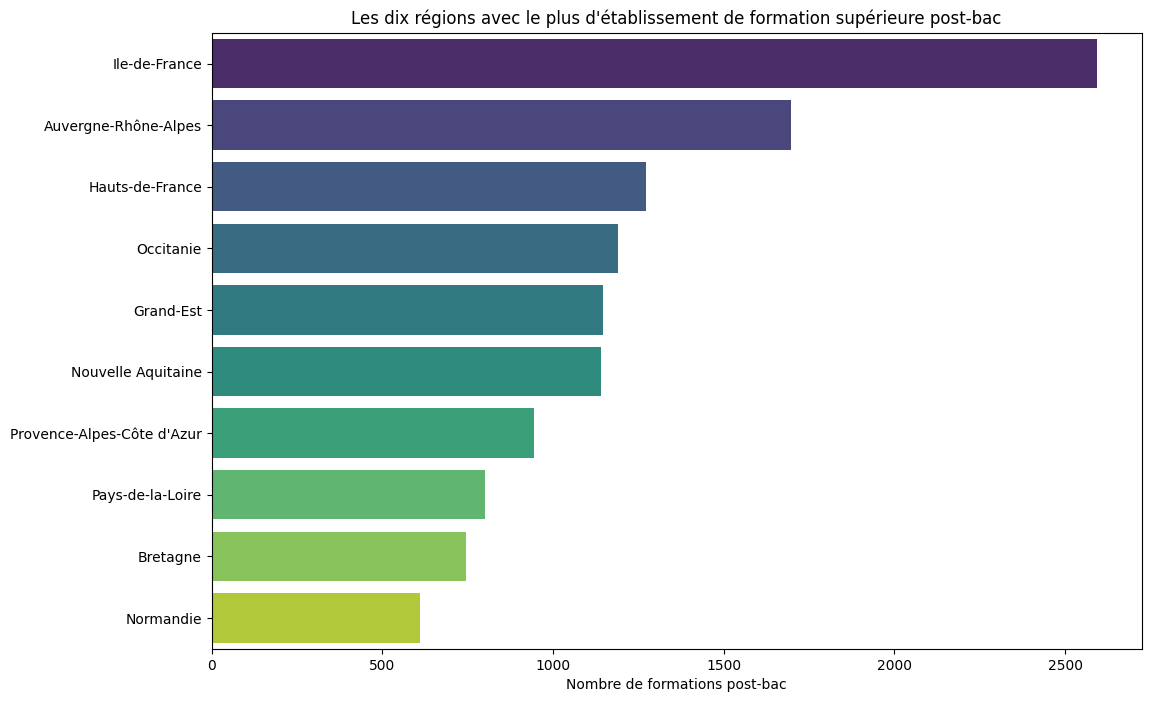

In [9]:
plt.figure(figsize=(12,8))

compt_region = df["region"].value_counts().head(10)

sns.barplot(
    x = compt_region.values,
    y = compt_region.index,
    palette="viridis"
)

plt.title("Les dix régions avec le plus d'établissement de formation supérieure post-bac")
plt.xlabel("Nombre de formations post-bac")
plt.ylabel("")
plt.show()

CARTE DES IMPLANTATIONS DE L ENSEIGNEMENT SUPERIEUR

Cette cartographie de l'offre de formation met en évidence de fortes disparités territoriales. En effet, l'Ile-de-France domine largement de paysage national de l'enseignement supérieur en concentrant une part très importante des établissements. Cette densité en ferait donc un pôle incontournable pour les étudiants qui cherchent des cursus spécifiques n'existant pas dans leur académie d'origine. 
En province, la région Auvergne-Rhône-Alpes se détache nettement, portée notamment par ses métropoles (Lyon ou Grenoble). Ailleurs, la répartition des formations semble plus homogène, même si la carte permet de reconnaître les grandes capitales régionales (Lille, Marseille, Toulouse, Bordeaux, Rennes).

Cette hétérogénéité de l'offre suggère donc une première hypothèse selon laquelle la mobilité étudiante serait en partie structurelle, puisqu'elle serait contrainte par la nécessité de rejoindre les pôles académiques disposant de l'offre recherchée. 

On cherche ainsi à voir si les étudiants non locaux sont plus nombreux dans les régions avec un grand nombre de formations. Ici, il faut noter que nous regardons les régions, qui regroupent plusieurs académies. 

In [10]:
print("Pourcentage d'étudiants locaux par région")

stats_geo = decrire_donnees(df, "region", "part_bac_ac_pcv")
display(stats_geo)

Pourcentage d'étudiants locaux par région


,nombre,Q1,médiane,Q3,moyenne
region,,,,,
Auvergne-Rhône-Alpes,1697,50.0,70.0,86.0,65.2
Occitanie,1190,50.0,71.0,86.0,66.4
Nouvelle Aquitaine,1140,50.0,71.0,86.0,65.9
Pays-de-la-Loire,802,55.0,75.5,89.0,69.3
Bourgogne-Franche-Comté,574,54.0,78.0,92.0,70.1
Bretagne,745,60.0,82.0,95.0,73.9
Grand-Est,1146,62.0,83.0,95.0,75.1
Centre,438,67.0,83.0,93.0,75.2
Provence-Alpes-Côte d'Azur,945,65.0,83.0,93.0,75.1


Contre toute attente, l'analyse du pourcentage d'étudiants locaux par région montre que ce n'est pas l'Île-de-France mais la région Auvergne-Rhône-Alpes qui apparaît comme la plus ouverte aux étudiants extérieurs. Cela s'expliquerait par la présence de plusieurs pôles universitaires importants (Lyon, Grenoble, Clermont-Ferrand) et proches géographiquement, favorisant donc les échanges inter-académiques. 
A l'inverse, l'Île-de-France affiche une forte proportion de locaux (médiane de 88% d'étudiants locaux) : l'importance et la diversité des formations franciliennes permettraient à une grande part des bacheliers franciliens de trouver une formation dans leur académie, limitant donc la part des provinciaux. 

Il convient néanmoins d'être plus précis et d'étudier ces flux entre académies, plutôt que régions.

*Note méthodologique* : pour éviter le biais des mobilités de "proximité" lors de notre étude par académie (par exemple vivre à Paris et étudier dans l'académie de Créteil), nous avons fusionné les académies de Paris, Créteil et Versailles. 

In [11]:
# Regroupement de Paris, Créteil et Versailles
df["academie_pcv"] = df["academie"].replace(
    ["Paris", "Créteil", "Versailles"], "Paris-Créteil-Versailles"
)

On calcule ensuite différents indicateurs. 
En regroupant par académie, on calcule le pourcentage de locaux en moyenne.

In [12]:
academies = df.groupby("academie_pcv")["part_bac_ac_pcv"].mean().reset_index()
display(academies.style.background_gradient(cmap="viridis", subset=["part_bac_ac_pcv"]))

,academie_pcv,part_bac_ac_pcv
0,Aix-Marseille,76.361017
1,Amiens,75.987342
2,Besancon,71.653226
3,Bordeaux,71.797078
4,Clermont-Ferrand,62.140127
5,Corse,78.136986
6,Dijon,68.923313
7,Etranger,44.294118
8,Grenoble,75.250432
9,Guadeloupe,91.078125


Passons maintenant à la visualisation graphique.

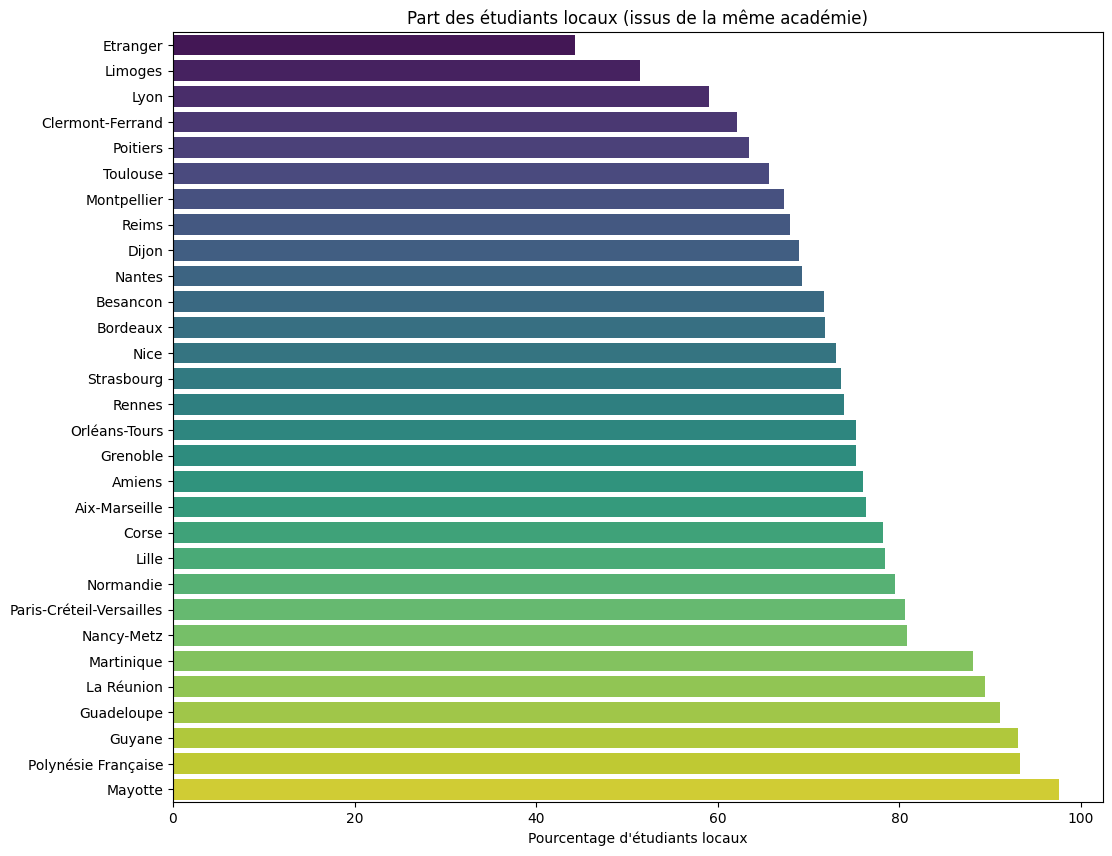

In [16]:
academies = academies.sort_values(by = "part_bac_ac_pcv", ascending=True)

plt.figure(figsize=(12,10))
sns.barplot(
    data=academies,
    x="part_bac_ac_pcv",
    y="academie_pcv",
    hue="academie_pcv",
    legend=False,
    palette="viridis",
)

plt.title("Part des étudiants locaux (issus de la même académie)")
plt.xlabel("Pourcentage d'étudiants locaux")
plt.ylabel("")
plt.show()

On calcule cette fois-ci le taux d'entrant.

In [17]:
academies["taux_entrants"] = 100 - academies["part_bac_ac_pcv"]

#tri pour connaître les académies les plus attractives
academies=academies.sort_values(by="taux_entrants", ascending=True)

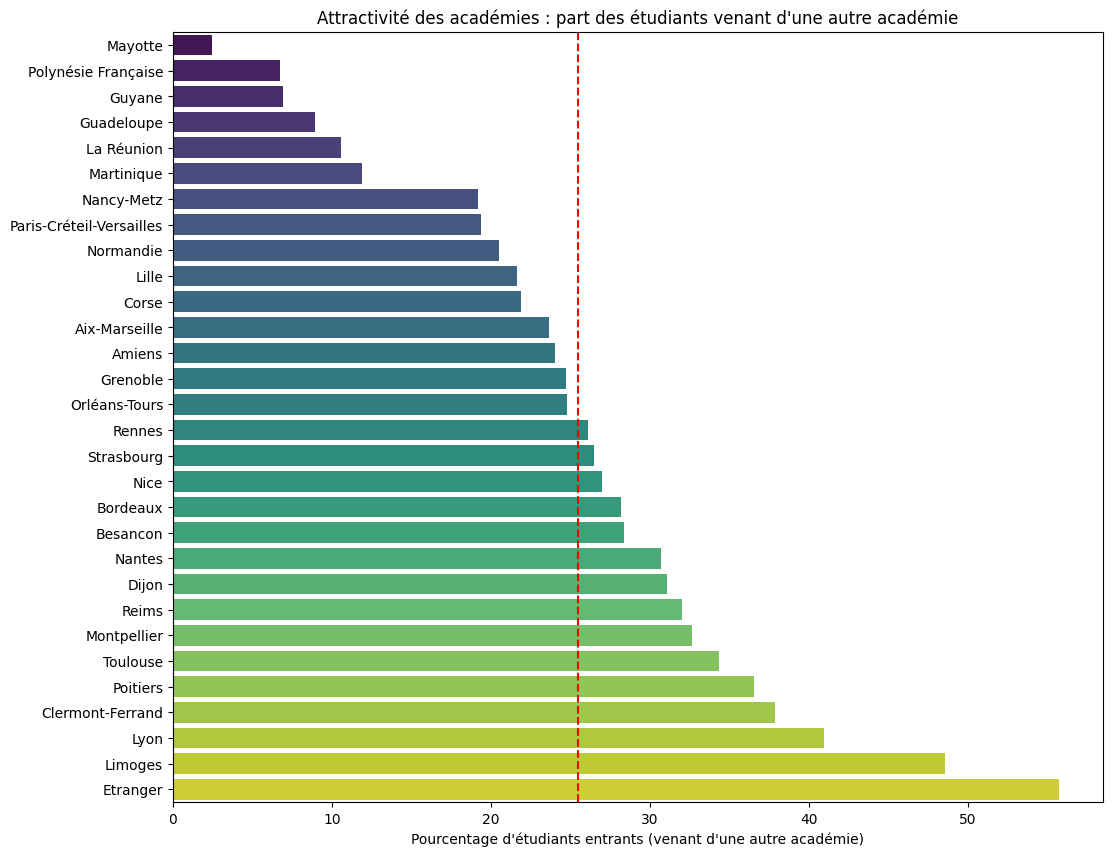

In [19]:
plt.figure(figsize=(12,10))
sns.barplot(
    data=academies,
    x="taux_entrants",
    y="academie_pcv",
    hue="academie_pcv",
    legend=False,
    palette="viridis"
)

plt.title("Attractivité des académies : part des étudiants venant d'une autre académie")
plt.xlabel("Pourcentage d'étudiants entrants (venant d'une autre académie)")
plt.ylabel("")

moyenne_nationale = academies["taux_entrants"].mean()
plt.axvline(x=moyenne_nationale, color="red", linestyle="--", label = f"Moyenne nationale ({moyenne_nationale:.1f}%)")

Etudier de façon détaillée les flux par académie permet d'identifier des dynamiques territoriales différentes et de former une typologie des académies : 
- Les capitales régionales permettant de soulager les métropoles voisines (Limoge, Clermont-Ferrand, Poitiers, Reims) : situées au centre de la France ou dans des zones démographiques peu dynamiques, ces académies disposent d'une offre de formation importante, de part leur histoire, qui pourrait excéder le nombre de bacheliers du territoire. Ainsi, elles semblent devoir recruter à l'extérieur de leur académie, permettant également de réguler la tension dans les métropoles saturées voisines. 

- Les zones sous tension (Nantes, Rennes, Bordeaux...) : ces académies semblent cumuler une démographie dynamique et une offre de formation attractive. Ainsi, la mobilité y serait souvent choisie, ce qui entraînerait une compétition plus importante. 

- L'insularité (Outre-mer, Corse) : leur éloignement géographique impose une sédentarité des étudiants puisqu'ils n'ont pas d'alternative à proximité. 

- L'exception lyonnaise : Lyon combine une forte attractivité (comme Paris) mais avec une ouverture plus grande, attirant vraisemblablement les étudiants des académies limitrophes. 

Ainsi, la mobilité n'est pas uniforme sur l'ensemble du territoire. Elle semble dépendre principalement de la tension entre l'offre de formation et la démographie locale.

Pour en savoir plus sur le lien entre l'offre de formation et la mobilité dans les académies, nous recherchons une corrélation entre la taille de l'académie (du point de vue du nombre d'étudiants qu'elle recrute chaque année) et la proportion d'étudiants locaux. 

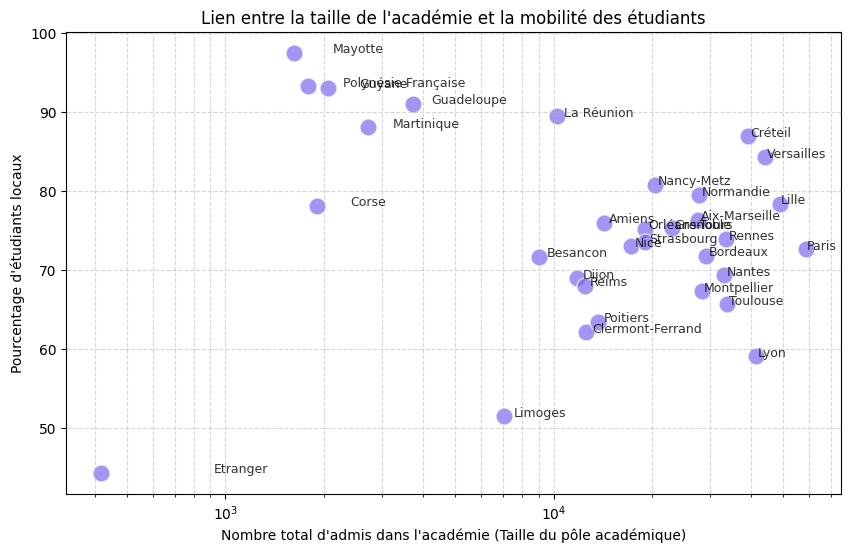

In [20]:
# Corrélation entre démographie mobilité

# Agglomération des données par académie
acad_stats = df.groupby("academie").agg({
    "nb_admis": "sum",             # Taille de l'académie (Nombre total d'étudiants)
    "part_bac_ac_pcv": "mean"      # Taux moyen de locaux
}).reset_index()

# Visualisation
plt.figure(figsize=(10, 6))

# Nuage de points
sns.scatterplot(
    data=acad_stats,
    x="nb_admis",
    y="part_bac_ac_pcv",
    s=150, 
    color="mediumslateblue",
    alpha=0.7
)

# Ajoute des noms des académies
for i in range(acad_stats.shape[0]):
    plt.text(
        x=acad_stats.nb_admis[i]+500, 
        y=acad_stats.part_bac_ac_pcv[i], 
        s=acad_stats.academie[i], 
        fontdict=dict(color='black', size=9),
        alpha=0.8
    )

plt.title("Lien entre la taille de l'académie et la mobilité des étudiants")
plt.xlabel("Nombre total d'admis dans l'académie (Taille du pôle académique)")
plt.ylabel("Pourcentage d'étudiants locaux")
plt.xscale("log") # Échelle log car Paris/Lille sont énormes par rapport à la Corse
plt.grid(True, which="both", linestyle="--", alpha=0.5)

plt.show()

Ce graphique permet de croiser la taille de l'académie (en nombre d'admis), en abscisse, et son taux de recrutement local, en ordonnée. La relation qui en résulte n'est pas linéaire, incitant à réfuter l'idée que plus une académie est grande, plus elle recrute localement. 

On observe en effet une courbe en U, permettant de dégager trois profils :

- A gauche, on observe des académies de petite taille, avec un fort pourcentage d'étudiants locaux, qui s'expliquerait principalement par leur insularité géographique. 

- Au centre, on observe des académies de taille moyenne avec une ouverture importante, par exemple Limoges, Clermont-Ferrand ou Reims. Elles sont assez grandes pour avoir une offre plutôt diversifiée mais leur vivier local semble insuffisant. Ainsi, elles importeraient structurellement les étudiants. 

- Enfin, à partir d'un certain nombre d'admis, la courbe remonte, semblant montrer que ces académies s'autosuffisent. Ce sont particulièrement des métropoles, qui parviendraient à garder leur propre population grâce à une vaste offre de formations.

<div style="background-color: #f8f9fa; color: #000000; border-left: 6px solid #8e44ad; padding: 15px; border-radius: 4px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
    <h4 style="color: #8e44ad; margin-top: 0;"> Analyse géographique de la mobilité dans l'enseignement supérieur</h4>
    <p>
        Cette analyse géographique révèle qu'une partie de la mobilité est structurelle. Elle met en évidence trois profils d'académies :
        <li> Les académies isolées (Corse, Outre-mer) qui recrutent localement par contrainte.
        <li> Les académies importatrices (Limoges, Reims) avec une offre de formation historique mais un bassin démographique faible.
        <li> Les métropoles autosuffisantes (Ile-de-France, Lille) dont la densité d'offre permet de retenir les étudiants locaux. 
    </p>
</div>

<a id="excellence"></a>
### Excellence scolaire: qui sont les élèves mobiles ?

On peut ensuite s'intéresser à l'effet de "brain drain" ou fuite des cerveaux, qui pourrait encourager les meilleurs élèves à quitter leur académie pour accéder aux filières les plus prestigieuses. 

Avant d'analyser les données par des graphiques, nous commençons par quelques statistiques descriptives concernant les filières et leur niveau afin de nous permettre de mieux appréhender le jeu de données.

In [21]:
print("Statistiques descriptives sur le volume des formations dans le jeu de données")
vol = df["filiere_agr"].value_counts().to_frame("Nombre d'établissements")
display(vol)

Statistiques descriptives sur le volume des formations dans le jeu de données


,Nombre d'établissements
filiere_agr,
BTS,5321
Licence,3000
Autre formation,1546
CPGE,982
BUT,818
Licence_Las,521
IFSI,517
Ecole d'Ingénieur,472
PASS,284


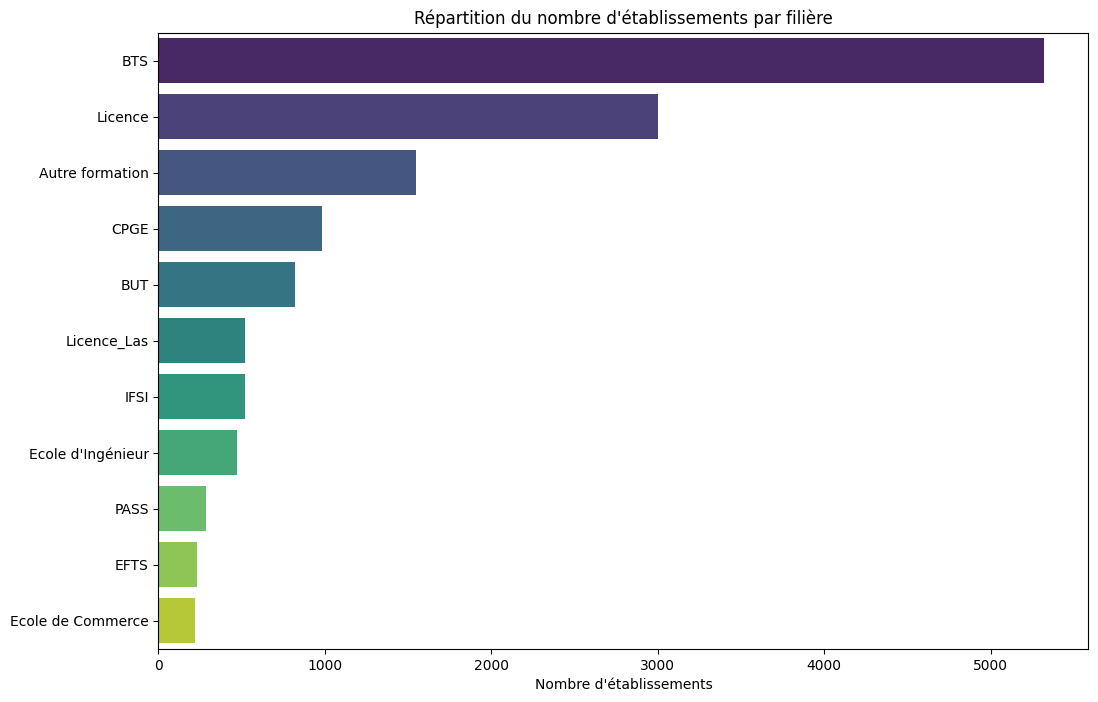

In [27]:
#Barplot permettant de voir visuellement le nombre d'établissements
plt.figure(figsize=(12,8))

compt = df["filiere_agr"].value_counts()

sns.barplot(x=compt.values, y=compt.index, hue=compt.index, palette="viridis")

plt.title("Répartition du nombre d'établissements par filière")
plt.xlabel("Nombre d'établissements")
plt.ylabel("")
plt.show()

La structure de l'offre de formation apparaît assez pyramidale. En effet, avec 5 321 formations, les BTS constituent la base. Leur volume massif peut s'expliquer par une logique de maillage territorial précis, les faisant apparaître comme une formation de proximité. Au centre de la pyramide, se trouvent les filières universitaires (Licences), concentrées dans les métropoles et pôles universitaires. Enfin, au sommet se trouvent les filières sélectives, plus rares. 

*Note méthodologique* : Le poids démographique des BTS dans le jeu de donnée doit être gardé en tête car il pourrait biaiser certains résultats. 

In [28]:
print("Niveau des admis selon la formation (pourcentage de mentions très bien)")

stats_niveau = decrire_donnees(df, "filiere_agr", "tb_eleves")
display(stats_niveau)

Niveau des admis selon la formation (pourcentage de mentions très bien)


,nombre,Q1,médiane,Q3,moyenne
filiere_agr,,,,,
Autre formation,1507,0.0,0.0,16.7,12.7
BTS,5304,0.0,0.0,5.3,3.5
EFTS,226,0.0,0.0,7.9,5.1
Ecole de Commerce,219,0.0,1.1,5.4,4.5
BUT,818,0.0,3.0,5.9,4.5
Licence_Las,517,0.0,3.6,11.1,8.3
Licence,2975,0.0,4.5,11.8,10.4
IFSI,516,1.6,4.5,8.3,7.3
Ecole d'Ingénieur,468,0.0,8.3,22.3,16.5


L'analyse du niveau scolaire (approximé par la mention Très Bien) des formations suggère une segmentation de l'enseignement supérieur. En effet, des filières comme les CPGE ou la PASS concentrent l'excellence scolaire. Les classes préparatoires dominent largement avec une moyenne de 33,3 % de mentions très bien (et jusqu'à 51% pour le dernier quartile !). Il faut néanmoins noter que, même si le niveau est élevé, la mobilité en PASS reste structurellement contrainte par la sectorisation, contrairement aux CPGE. 

A l'inverse, des formations plus professionnalisantes, comme les BTS, avec une médiane de 0% de mentions très bien, accueillent des étudiants scolairement moins favorisés. Cela s'explique par leur objectif d'insertion et de proximité. 

L'université et les écoles post-bac occupent une position intermédiaire. 

Nous cherchons également à voir le rôle de la filière dans la mobilité.

CARTE DE LA REPARTITION DES DIFFERENTES FILIERES

/tmp/ipykernel_80255/1264558400.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


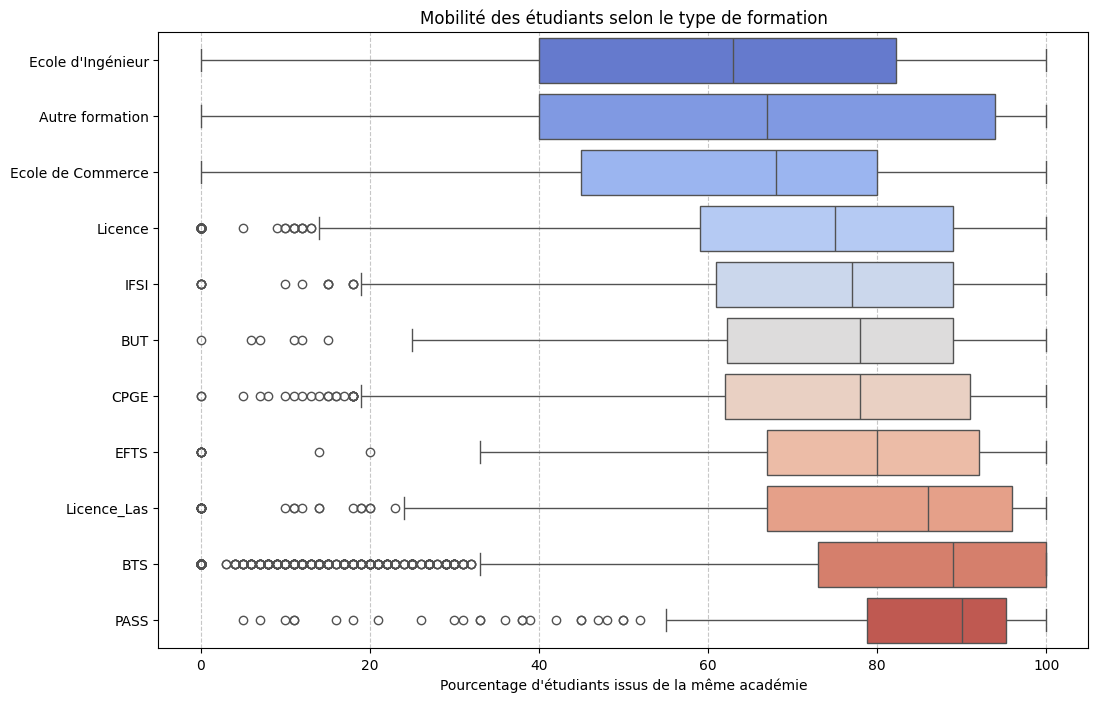

In [34]:
# Role de la filière dans la mobilité

plt.figure(figsize=(12, 8))

# Tri des filières de la "Plus Mobile" (en haut) à la "Plus Locale" (en bas) 
# en utilisant la médiane pour être robuste aux valeurs extrêmes
ordre_filieres = df.groupby("filiere_agr")["part_bac_ac_pcv"].median().sort_values().index

# 2. Le Boxplot
sns.boxplot(
    data=df,
    x="part_bac_ac_pcv", # Taux de locaux
    y="filiere_agr",     # Type de filière
    order=ordre_filieres,
    palette="coolwarm" # Rouge = Local, Bleu = Mobile
)

plt.title("Mobilité des étudiants selon le type de formation")
plt.xlabel("Pourcentage d'étudiants issus de la même académie")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

Ce graphique confirme l'existence d'une corrélation entre le type de filière et l'ouverture géographique. 

En effet, les filières d'élite (ingénieurs, commerce, CPGE) affichent des taux de recrutement local relativement faibles. Ce sont des formations dont le marché est national. 

Au contraire, certaines filières, comme les BTS recrutent majoritairement localement. Cela permet de répondre à une logique de bassin d'emploi local. Cependant l'importance des valeurs extrêmes, révèle l'existence de formations de niche. Par exemple, certains BTS très spécialisés ou rares recrutent sur l'ensemble du territoire. 

De même, il existe une fracture au sein des CPGE avec d'un côté les prépas de proximité qui recrutent localement alors que les "grandes prépas" ont un recrutement national (grâce notamment à la présence d'internats). 

Concernant les licences, la règle par défaut est souvent l'université de secteur, ce qui explique une médiane assez élevée. Mais la taille de la boîte étant assez importante, cela pourrait laisser penser à l'existence d'un certain type de licence qui attirerait les étudiants de loin (double licences ou licences prestigieuses) et échapperaient donc à la sectorisation.

Nous croisons maintenant le type de filière avec le niveau d'excellence de la formation, qui est calculé à partir de la part d'étudiant ayant eu une mention très bien au bac. 

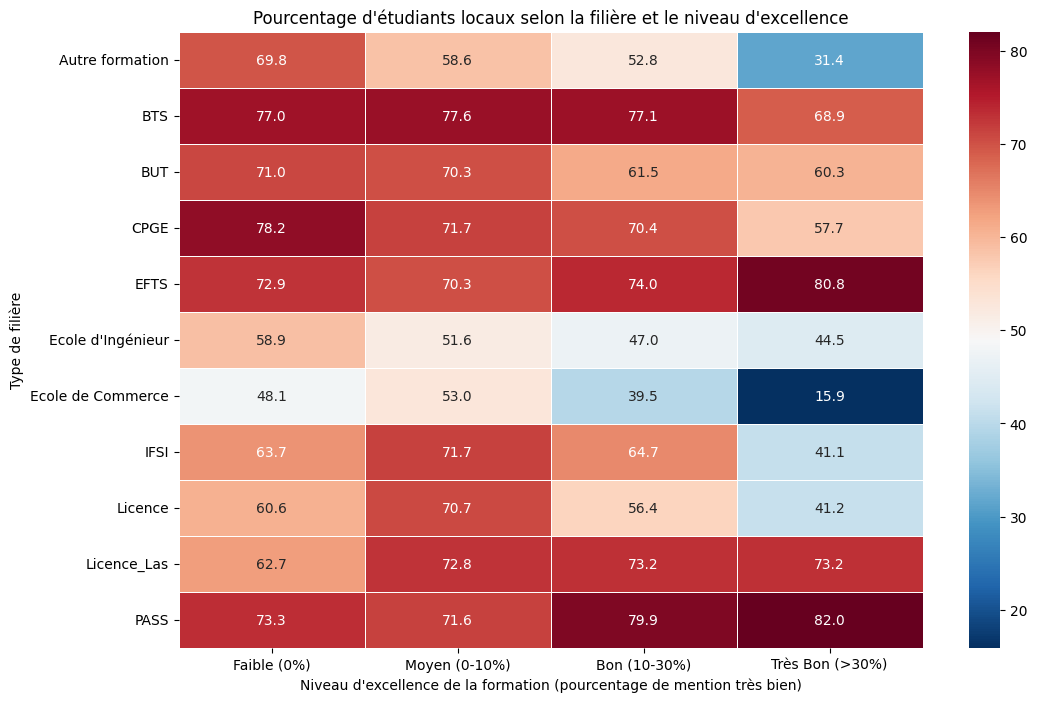

In [39]:
pivot_excellence = df.pivot_table(
    index="filiere_agr",
    columns="niveau_formation",
    values="part_bac_ac",
    aggfunc="mean",
    observed=False
)

plt.figure(figsize=(12,8))

sns.heatmap(
    pivot_excellence,
    annot=True,
    fmt=".1f",
    cmap="RdBu_r",
    linewidths=.5
)

plt.title("Pourcentage d'étudiants locaux selon la filière et le niveau d'excellence")
plt.xlabel("Niveau d'excellence de la formation (pourcentage de mention très bien)")
plt.ylabel("Type de filière")

plt.show()

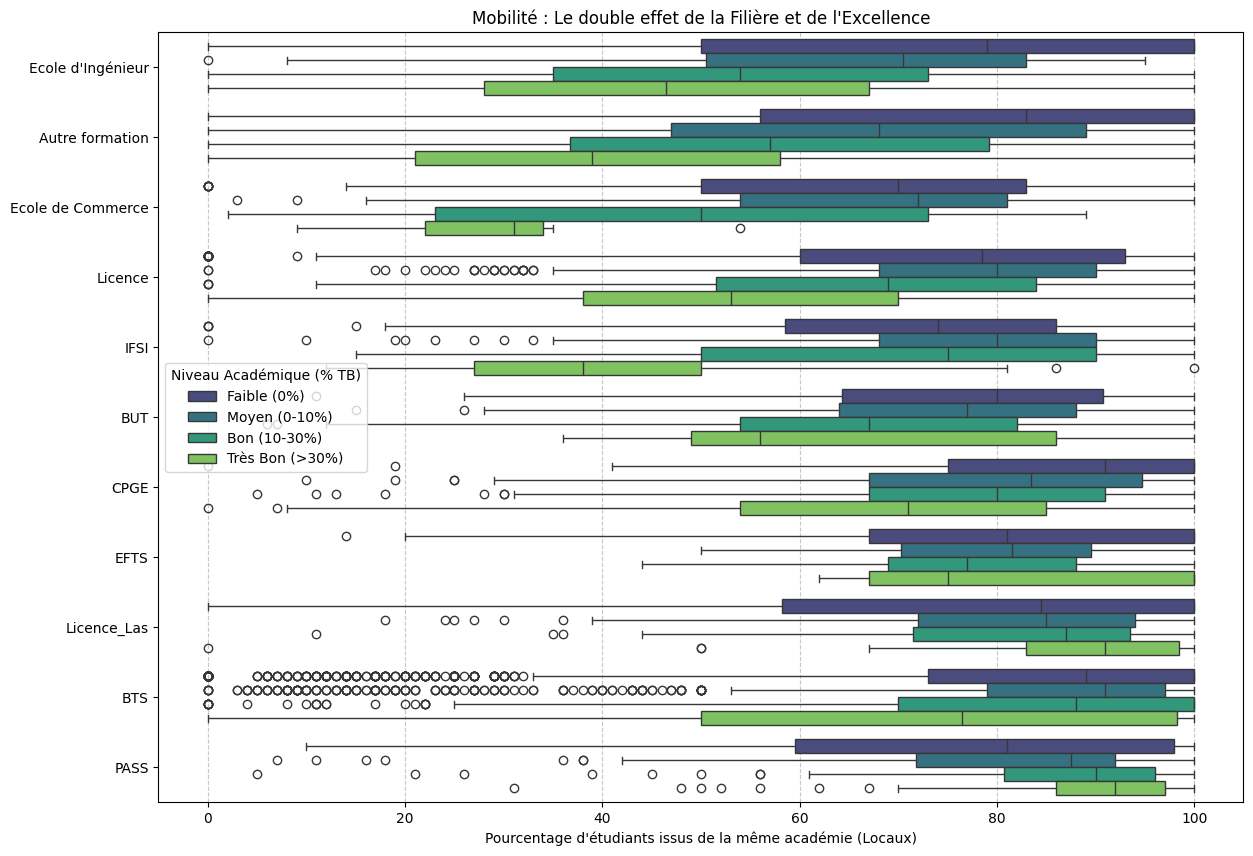

In [40]:

plt.figure(figsize=(14, 10))

#Tri des filières
ordre_filieres = df.groupby("filiere_agr")["part_bac_ac_pcv"].median().sort_values().index

# Boxplot avec la dimension Excellence (hue)
sns.boxplot(
    data=df,
    x="part_bac_ac_pcv", 
    y="filiere_agr",     
    hue="niveau_formation", 
    order=ordre_filieres,
    palette="viridis" # Une couleur par niveau d'excellence
)

plt.title("Mobilité : Le double effet de la Filière et de l'Excellence")
plt.xlabel("Pourcentage d'étudiants issus de la même académie (Locaux)")
plt.ylabel("")
plt.legend(title="Niveau Académique (% TB)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

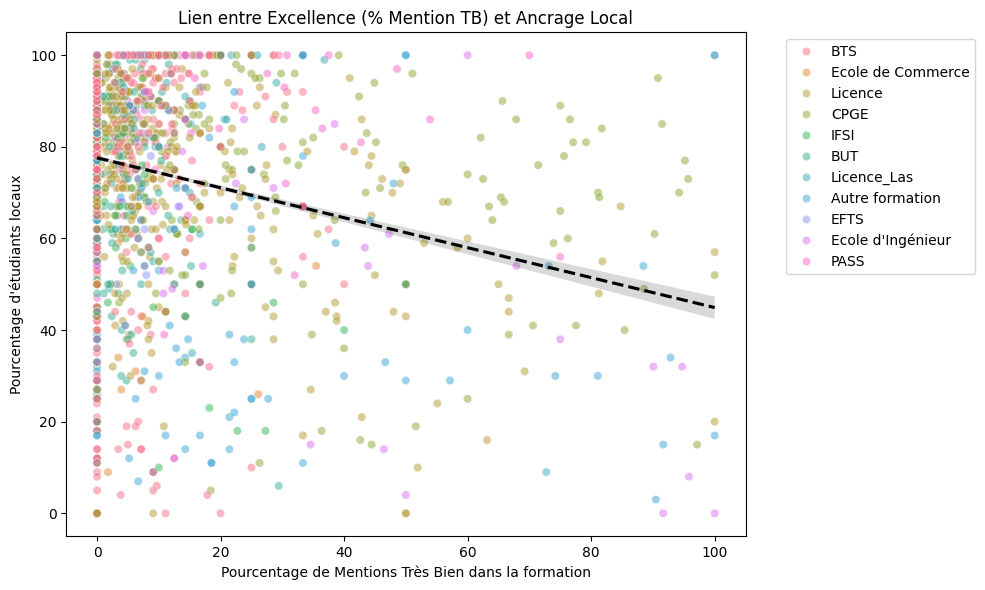

In [41]:
# Preuve qu'il existe une corrélisation entre le niveau de la formation (nombre de mention TB) et mobilité

plt.figure(figsize=(10, 6))

# On prend un échantillon pour ne pas surcharger le graphique
sample_df = df.sample(2000, random_state=42)

sns.scatterplot(
    data=sample_df,
    x="tb_eleves",       # % de mention TB
    y="part_bac_ac_pcv", # % de locaux
    hue="filiere_agr",   # Une couleur par filière pour voir les groupes
    alpha=0.5
)

# On ajoute la courbe de tendance globale (Régression)
sns.regplot(
    data=df, 
    x="tb_eleves", 
    y="part_bac_ac_pcv", 
    scatter=False, 
    color="black", 
    line_kws={"linestyle": "--"}
)

plt.title("Lien entre Excellence (% Mention TB) et Ancrage Local")
plt.xlabel("Pourcentage de Mentions Très Bien dans la formation")
plt.ylabel("Pourcentage d'étudiants locaux")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Le croisement entre le niveau académique (pourcentage de mention très bien) et l'ancrage local, représenté par les trois graphiques précédents, montre une corrélation négative entre le niveau et l'ancrage local. En effet, plus le niveau d'une formation augmente, moins son recrutement est local. 

Le système éducatif se divise donc en deux ensembles : un marché de proximité qui propose des formations généralistes ou professionnalisantes, plutôt local (en haut à gauche) et, plus rare, un marché compétitif qui propose des formations prestigieuses, recrutant les meilleurs profils sur le territoire national. 

Ainsi, l'excellence scolaire est un vecteur de mobilité puisqu'elle permet de viser ces formations d'excellence. 

<div style="background-color: #fffcf5; color: #000000; border-left: 6px solid #f1c40f; padding: 15px; border-radius: 4px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
    <h4 style="color: #d4ac0d; margin-top: 0;"> L'excellence facilite la mobilité</h4>
    <p style="color: #000000;">
        Les données confirment l'hypothèse du "Brain Drain" académique, selon lequel les formations prestigieuses attirent des étudiants de l'ensemble du territoire :
        <ul style="color: #000000;">
            <li>Il existe une dualité du marché, opposant les formations d'élite (CPGE, Grandes Écoles) qui recrutent nationalement et les formations courtes (BTS) ou universitaires qui recrutent localement.</li>
            <li>L'excellence permet la mobilité : plus une formation est sélective scolairement (taux de Mentions TB élevé), plus ses étudiants viennent de loin.</li>
        </ul>
        Cependant, cette mobilité se heurte à une contrainte physique : le nombre de places disponibles. Nous pouvons donc étudier l'effet de la sélectivité.
    </p>
</div>

<a id="selectivite"></a> 
### La sélectivité

Alors que l'excellence académique caractérise la demande, la sélectivité est une caractéristique intrinsèque à l'offre. Les deux sont extrêmement liées puisque les meilleurs élèves cherchent les formations les plus sélectives. 

Pour mesurer cette sélectivité, nous utilisons le taux d'accès, donné directement dans la base de données. On se demande ainsi si un taux d'accès faible, signifiant que la formation est sélective, engendre un taux de mobilité plus élevé chez les étudiants suivant cette formation.

In [42]:
print("Sélectivité des filières (taux d'accès en pourcentage)")

stats_selectivite = decrire_donnees(df, "filiere_agr", "taux_acces_clean")

display(stats_selectivite)

Sélectivité des filières (taux d'accès en pourcentage)


,nombre,Q1,médiane,Q3,moyenne
filiere_agr,,,,,
PASS,284,23.0,35.5,49.0,39.8
IFSI,517,24.0,38.0,51.0,37.8
EFTS,234,34.2,45.0,58.0,46.9
Autre formation,1509,20.0,46.0,76.0,48.4
BUT,818,30.0,49.5,72.0,50.6
Licence_Las,521,34.0,59.0,89.0,59.5
BTS,5321,40.0,62.0,83.0,60.6
CPGE,982,34.0,62.5,84.0,58.8
Ecole de Commerce,219,44.0,63.0,74.5,58.6


Cette analyse des taux d'accès révèle que les tensions sont différentes selon les filières. 

En effet, les formations dans les métiers de la santé (PASS ou IFSI) affichent des taux d'accès assez faible. Cette saturation de l'offre devrait encourager la mobilité, cependant celle-ci apparaît freinée par la sectorisation qui favorise les étudiants locaux. 

De manière étonnante, les classes préparatoire affichent un taux d'accès médian de 62,5%, en faisant une formation relativement simple à intégrer. Cependant, ce chiffre marque une forte hétérogénéité entre les prépas, comme le montre l'écart interquartile élevé. En effet, il existe vraisemblablement une grande différences entre les "petites" prépas de province (facilement accessibles) et les "grandes prépas" très sélectives. 

Les licences ont un taux d'accès très élevés, jouant donc leur rôle d'accueil. 

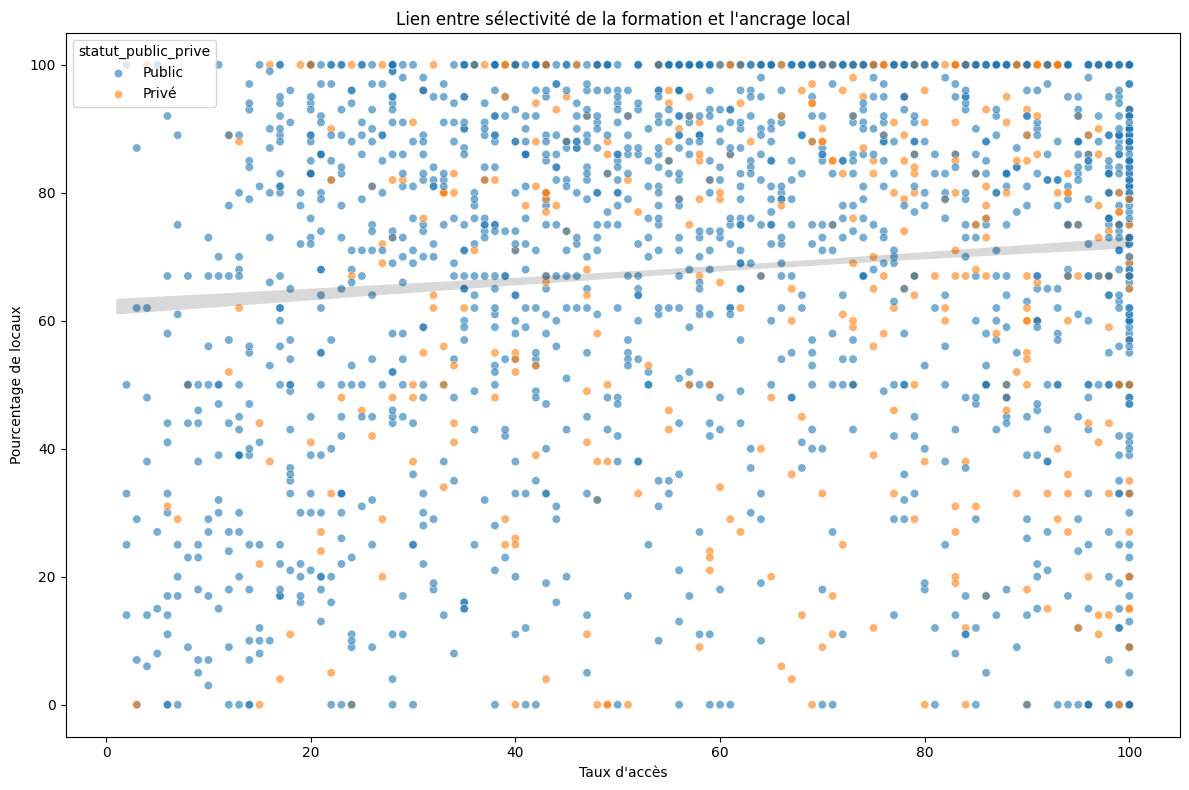

In [43]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df.sample(2000, random_state=42),
    x="taux_acces_clean",
    y="part_bac_ac",
    hue="statut_public_prive",
    alpha=0.6
)

sns.regplot(
    data=df,
    x="taux_acces_clean",
    y="part_bac_ac",
    scatter=False,
    color="black",
    line_kws={"linestyle":""}
)

plt.title("Lien entre sélectivité de la formation et l'ancrage local")
plt.xlabel("Taux d'accès")
plt.ylabel("Pourcentage de locaux")

plt.tight_layout()
plt.show()

Il existe une corrélation positive entre le taux d'accès et la part d'étudiants locaux, ce qui peut s'interpréter d'un point de vue économique. En effet, les formations ouvertes (à droite du graphe) recrutent principalement localement. Lorsque le taux d'accès est élevé, l'étudiant a peu d'intérêt à supporter le coût de la mobilité s'il peut accéder à une formation identique et proche de chez lui. Au contraire, les formations sélectives (à gauche du graphe) recrutent une part de locaux moindre. En effet, la sélectivité transforme la formation en un bien rare, dont la valeur compense alors le coût de la mobilité. Cependant, les différences entre les filières sélectives ou non n'apparaissent pas flagrantes sur ce graphique, laissant penser que sont effet n'est peut être pas majeur.

<div style="background-color: #fff8e1; color: #000000; border-left: 6px solid #e67e22; padding: 15px; border-radius: 4px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
    <h4 style="color: #d35400; margin-top: 0;">La rareté justifie la distance</h4>
    <p style="color: #000000;">
        La mobilité répond à un calcul coût/avantage rationnel :
        <ul style="color: #000000;">
            <li>Quand une formation est facile d'accès (Licences, certains BTS), les étudiants privilégient la proximité pour minimiser les coûts.</li>
            <li>Quand une formation est sélective (bien rare), les étudiants acceptent la mobilité.</li>
        </ul>
        Bien que prestigieuses, beaucoup de prépas de province peinent à remplir leurs classes, créant des opportunités d'accès inattendues, contrairement aux BUT ou IFSI souvent saturés.
        
</p>
</div>

Cette sélectivité peut s'avérer particulièrement forte dans les filières gratuites et publiques, ce qui nous pousse à nous interroger sur le statut de l'établissement. 

<a id="public_prive"></a> 
### Le clivage public/privé 

On se demande donc si le statut de l'établissement joue un rôle dans son ouverture géographique. En effet, le privé étant souvent moins saturé pourrait engendrer une mobilité différente du public. 

In [44]:
print("Ancrage local (pourcentage de locaux) selon le statut de la formation")
stats_mob_statut = decrire_donnees(df, "statut_public_prive", "part_bac_ac_pcv")
display(stats_mob_statut)

Ancrage local (pourcentage de locaux) selon le statut de la formation


,nombre,Q1,médiane,Q3,moyenne
statut_public_prive,,,,,
Privé,2933,56.0,80.0,94.0,71.3
Public,10981,62.0,82.0,94.0,74.7


/tmp/ipykernel_80255/2051280368.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


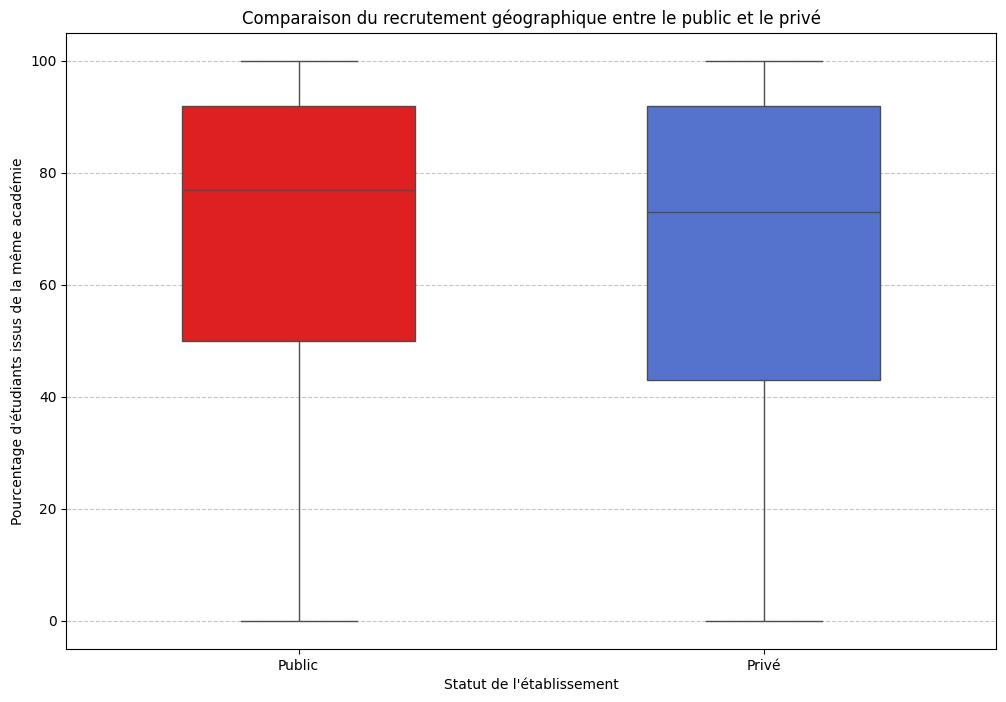

In [48]:
#On ne garde que le public et le privé
statut_filtre = df[df["statut_public_prive"].isin(["Public", "Privé"])]

plt.figure(figsize=(12,8))

sns.boxplot(
    data=statut_filtre,
    x="statut_public_prive",
    y="part_bac_ac",
    palette=couleurs_statut,
    width=0.5
)

plt.title("Comparaison du recrutement géographique entre le public et le privé")
plt.xlabel("Statut de l'établissement"),
plt.ylabel("Pourcentage d'étudiants issus de la même académie")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

La comparaison des taux de recrutement local met en évidence une logique de proximité pour le public. Avec une médiane de 82% d'étudiants locaux, le secteur public semble assurer une mission de service public de proximité. Sa dispersion territoriale dense et les politiques de sectorisation favoriseraient un recrutement local. 

A l'inverse, le secteur privé tend à mettre en avant une logique de marché. Il apparaît plus mobile que le public avec une médiane de 78% de locaux, une ouverture qui s'explique par des facteurs économiques et psychologiques. Ainsi, pour une famille prête à payer des frais de scolarité élevés, le surcoût lié à la mobilité serait plus facilement accepté que pour une formation publique gratuite. De plus, les écoles privées tendent à déployer des stratégies de communication de grande ampleur pour recruter. Cependant, la dispersion importante observée dans le privé montre une réalité hétérogène, allant sûrement d'une grande école de commerce à une petite école privée jouant le rôle de "seconde chance". 

In [49]:
print("Taux d'accès (sélectivité) selon le statut de la formation")
stats_sel_statut = decrire_donnees(df, "statut_public_prive", "taux_acces_clean")
display(stats_sel_statut)

Taux d'accès (sélectivité) selon le statut de la formation


,nombre,Q1,médiane,Q3,moyenne
statut_public_prive,,,,,
Public,10945,34.0,56.0,85.0,57.9
Privé,2927,50.0,73.0,90.0,68.2


/tmp/ipykernel_80255/2484961422.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


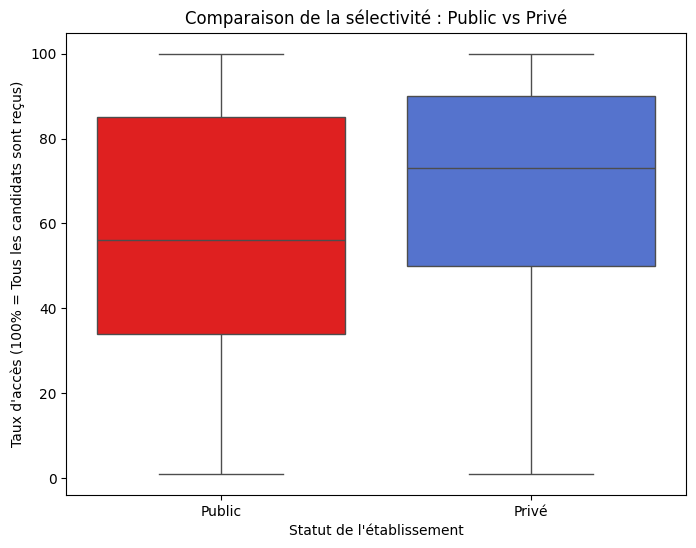

In [50]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    data=df,
    x="statut_public_prive",
    y="taux_acces_clean",
    palette=couleurs_statut
)

plt.title("Comparaison de la sélectivité : Public vs Privé")
plt.xlabel("Statut de l'établissement")
plt.ylabel("Taux d'accès (100% = Tous les candidats sont reçus)")
plt.show()

En croisant avec la sélectivité, on s'aperçoit que, statistiquement, le public est plus sélectif que le privé. 

En effet, avec un taux d'accès médian de seulement 56,5%, le service public concentre la tension. La gratuité et la qualité des formations attireraient les candidats pour un nombre de places limité.

A l'inverse, le secteur privé a une médiane d'accès plus élevée. Il existerait tout d'abord une autocensure économique qui réduit le nombre de candidats. De plus, de nombreuses écoles chercheraient activement des étudiants pour remplir leurs promotions et assurer leur équilibre économique. 

Ainsi, un étudiant refusé dans une filière publique locale sous tension se tournerait fréquemment vers une alternative privée, plus accessible, quitte à quitter son académie d'origine. 

<div style="background-color: #eefbff; color: #000000; border-left: 6px solid #3498db; padding: 15px; border-radius: 4px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
    <h4 style="color: #2980b9; margin-top: 0;">Une différence de logique
    <p style="color: #000000;">
        L'analyse du statut révèle une mécanique de vases communicants :
        <ul style="color: #000000;">
            <li>Le public, sous tension et fortement local est soumis à une forte pression (taux d'accès 56%) : il remplirait sa mission de proximité mais sature vite.</li>
            <li>Le privé, plus ouvert et mobile grâce au filtre du prix, attirerait des étudiants prêts à bouger pour trouver une place.</li>
        </ul>
        La mobilité vers le privé serait donc souvent une réponse à la saturation du public local.
    </p>
</div>

Ainsi, nous venons d'explorer différentes contraintes, mais une barrière invisible, purement sociologique, le genre, pourrait également jouer un rôle important dans la structuration des flux. 

<a id="genre"></a> 
### L'influence du genre

L'analyse de l'influence du genre sur la mobilité s'appuie sur deux mécanismes : 
- Une différence dans la réussite scolaire : les filles obtiennent de meilleurs résultats au bac et au lycée que les garçons. Or, comme nous l'avons vu, l'excellence scolaire semble être un vecteur de mobilité. Ainsi, on pourrait s'attendre à une mobilité accrue dans les formations plutôt féminines.
- Une ségrégation des filières : les choix d'orientation sont encore très genrés. Les garçons se dirigent plutôt vers des filières scientifiques ou techniques et industrielles, ces dernières étant souvent courtes et locales (BTS), tandis que les filles se dirigent plutôt vers des formations de soin, langue ou sciences humaines dont le maillage territorial est différent. 

Nous cherchons donc à savoir si ces dynamiques se traduisent par une différence dans l'ancrage territorial des formations à dominante féminine et masculine. 

A noter : nous avons calculé une variable "part_filles" pour indiquer la dominante de genre dans chaque formation. Ainsi, une formation à dominante masculine sera constituée de moins de 40% de filles et une formation à dominante féminine sera constituée de plus de 60% de filles. 

In [53]:
print("Répartition des formations par genre")

repartition_genre = df["categorie_genre"].value_counts().to_frame("Nombre d'établissements")
display(repartition_genre)

Répartition des formations par genre


,Nombre d'établissements
categorie_genre,
Dominante féminine,5960
Dominante masculine,5060
Mixte,2894


CARTE DE GENRE (mettre les deux)

/home/onyxia/work/Projet-python-data-science/function.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)
/home/onyxia/work/Projet-python-data-science/function.py:310: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)


Fond de carte non disponible, affichage des points uniquement.


/home/onyxia/work/Projet-python-data-science/function.py:326: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ctype, data in gdf.groupby('categorie_genre'):


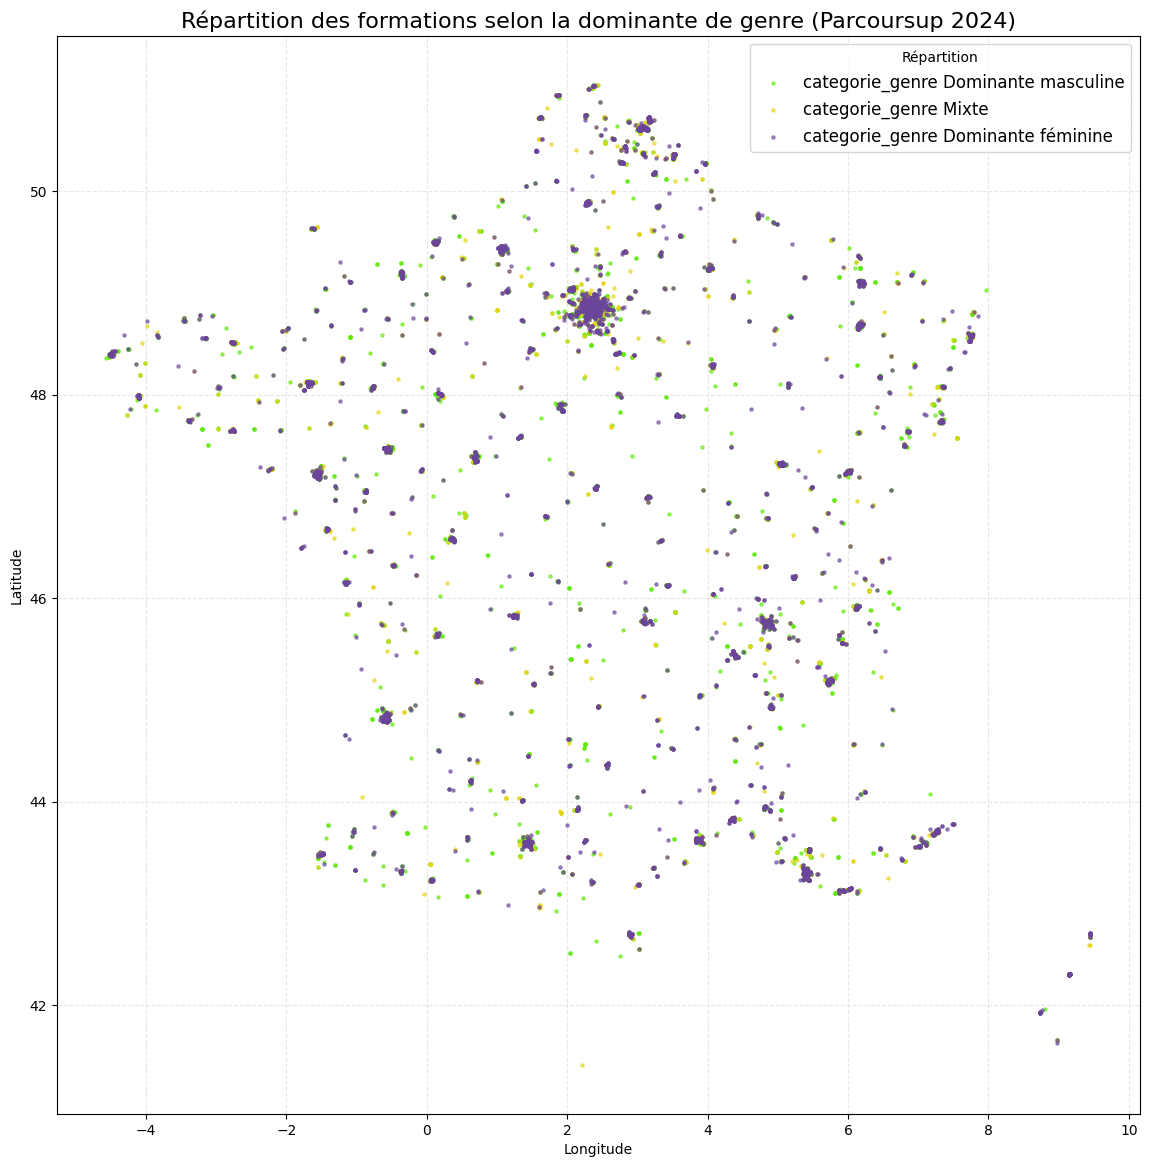

Carte générée : carte_parcoursup_genre.png


In [55]:
#from function import Gender_card, Gender_card_by_way
Gender_card(df)

/home/onyxia/work/Projet-python-data-science/function.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)
/home/onyxia/work/Projet-python-data-science/function.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)


Fond de carte non disponible, affichage des points uniquement.


/home/onyxia/work/Projet-python-data-science/function.py:375: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for  ctype, data in gdf.groupby('categorie_genre'):


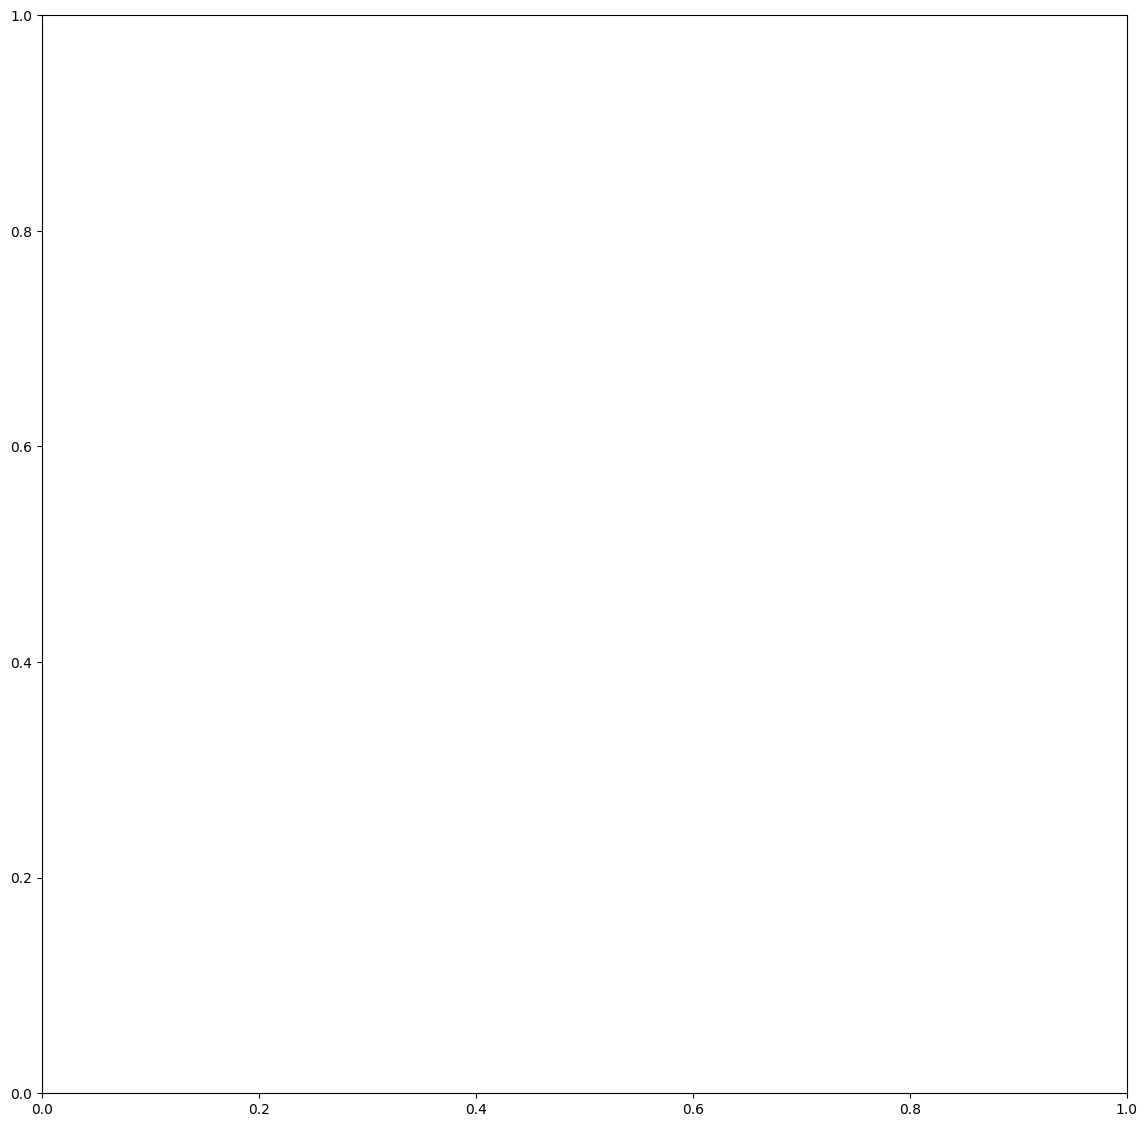

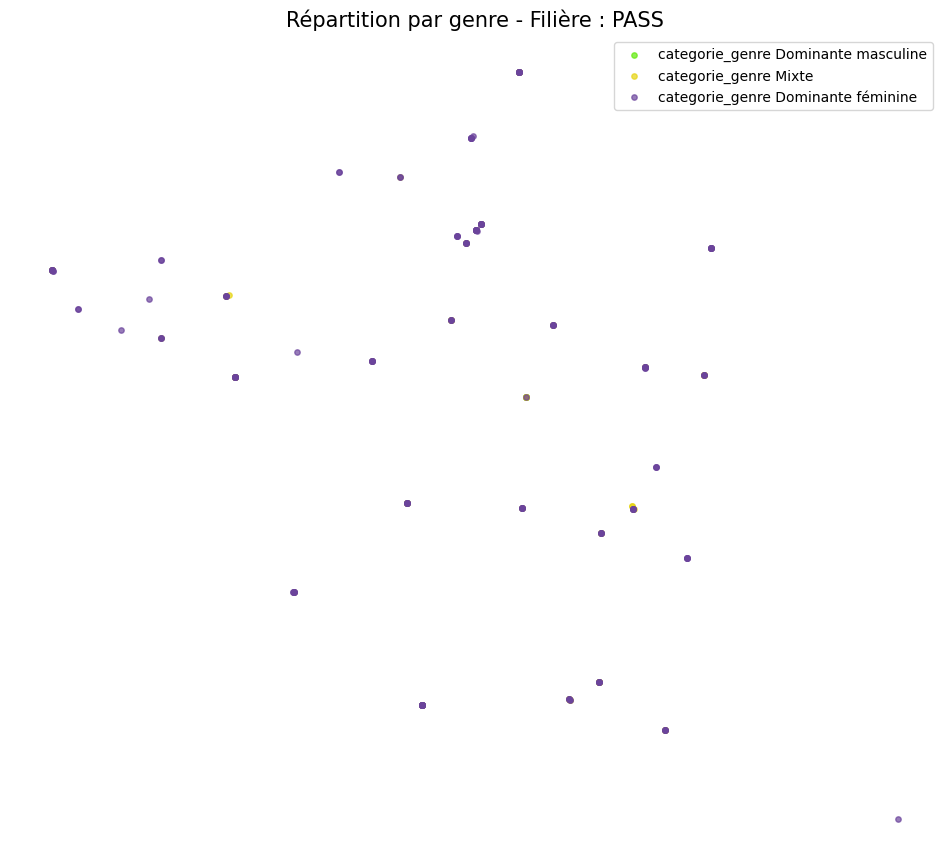

In [60]:
Gender_card_by_way(df, "PASS")

/home/onyxia/work/Projet-python-data-science/function.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)
/home/onyxia/work/Projet-python-data-science/function.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)


Fond de carte non disponible, affichage des points uniquement.


/home/onyxia/work/Projet-python-data-science/function.py:375: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for  ctype, data in gdf.groupby('categorie_genre'):


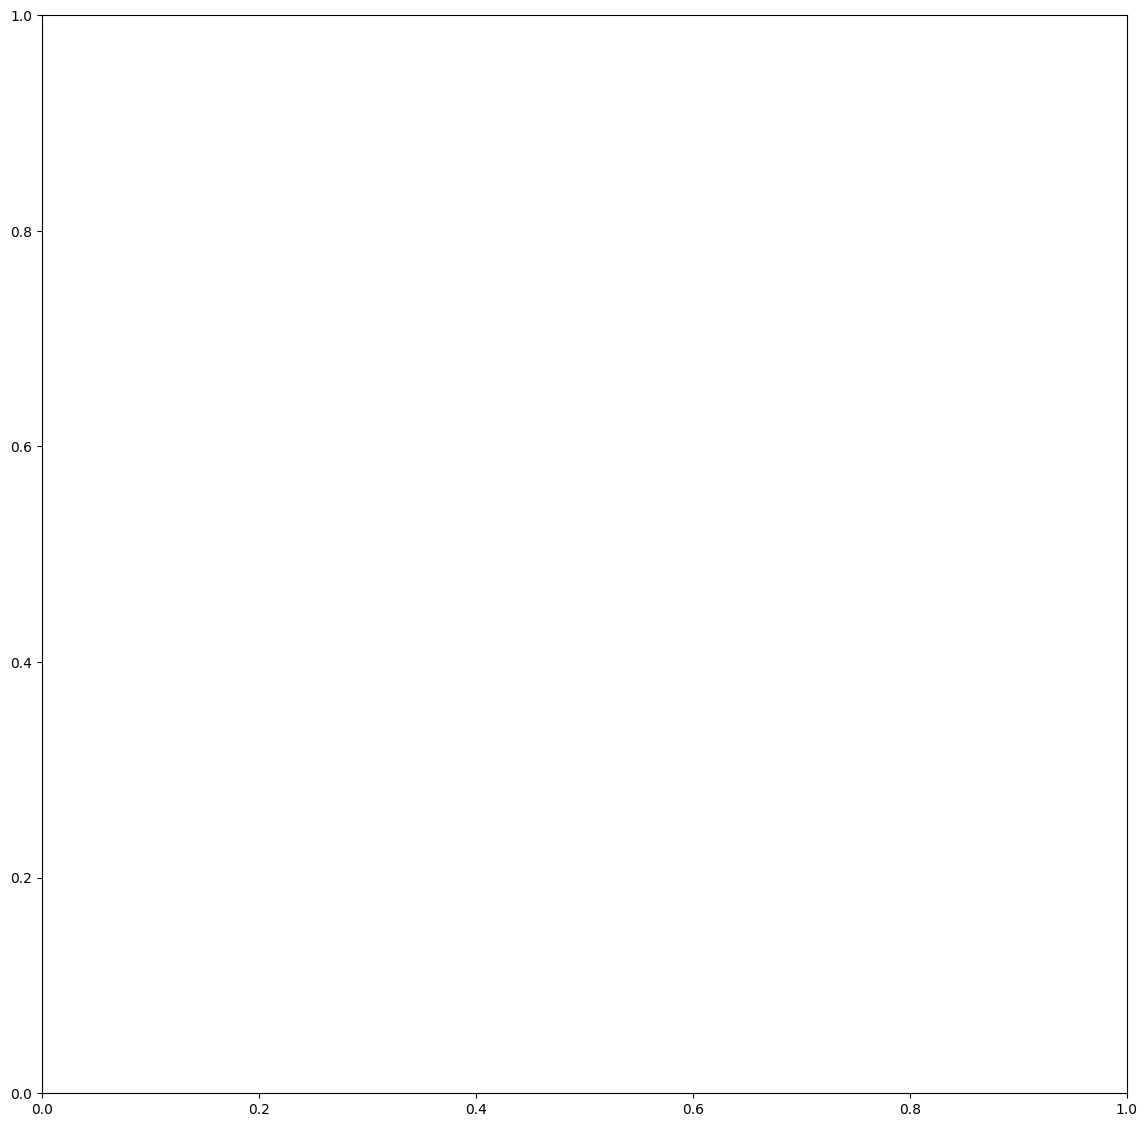

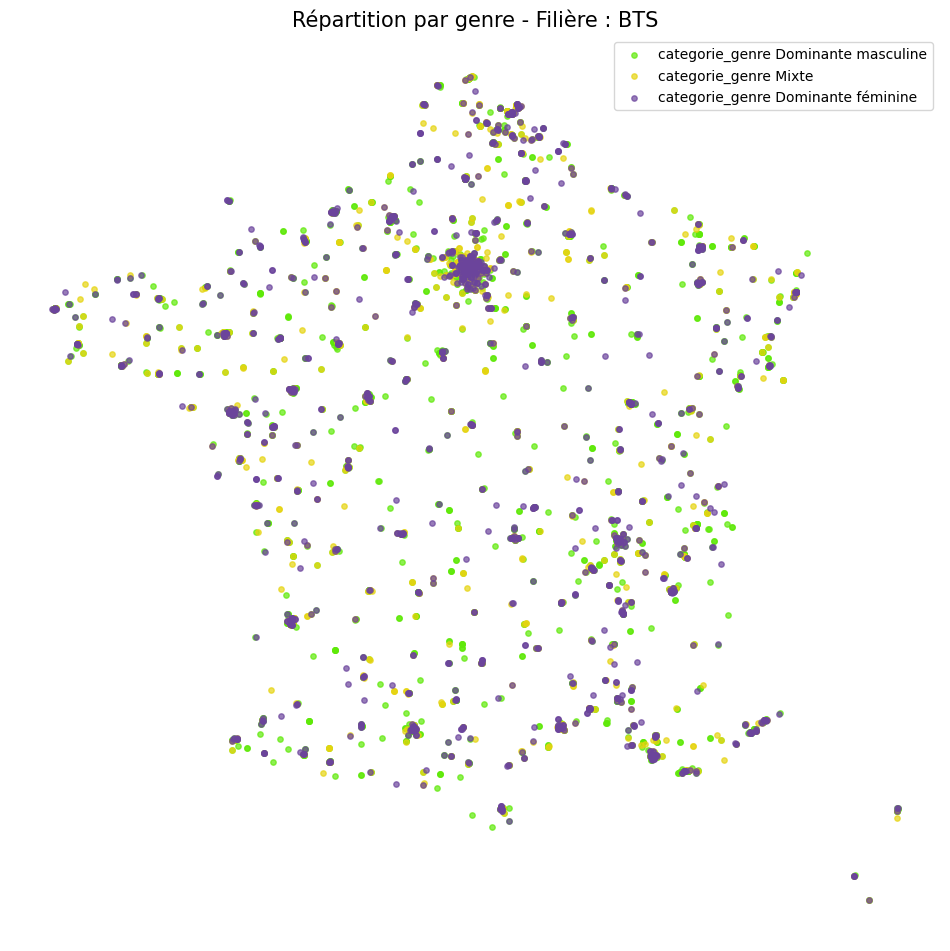

In [61]:
Gender_card_by_way(df, "BTS")

/home/onyxia/work/Projet-python-data-science/function.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)
/home/onyxia/work/Projet-python-data-science/function.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['lat', 'lon']] = df["coord_GPS"].str.split(',', expand=True).astype(float)


Fond de carte non disponible, affichage des points uniquement.


/home/onyxia/work/Projet-python-data-science/function.py:375: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for  ctype, data in gdf.groupby('categorie_genre'):


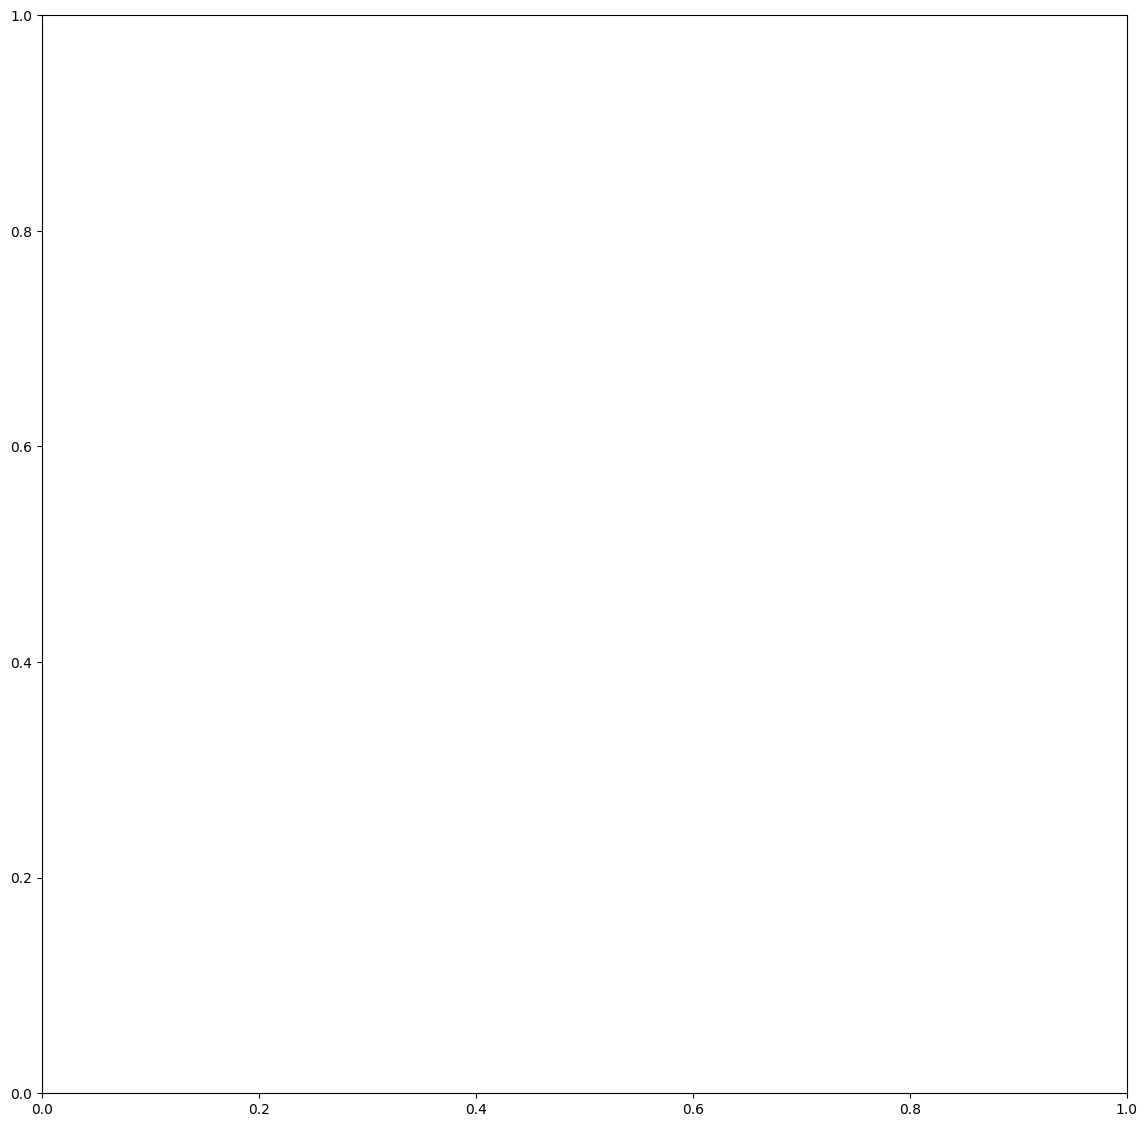

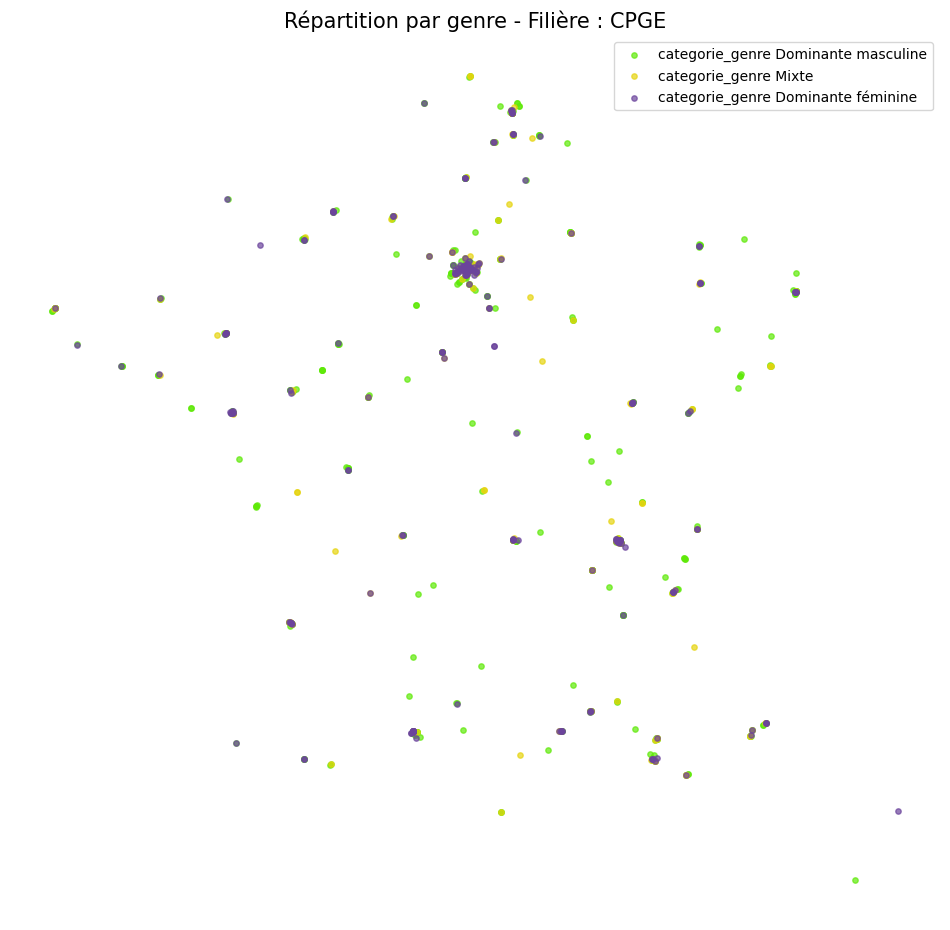

In [63]:
Gender_card_by_way(df, "CPGE")

Le paysage de l'enseignement supérieur apparaît polarisé par des formations à dominante féminine d'un côté et des formations à dominante masculine de l'autre, la mixité semblant être une exception.

In [64]:
print("Féminisation par filière (pourcentage de filles admises)")
stats_genre = decrire_donnees(df, "filiere_agr", "part_filles")
display(stats_genre)

Féminisation par filière (pourcentage de filles admises)


,nombre,Q1,médiane,Q3,moyenne
filiere_agr,,,,,
Ecole d'Ingénieur,472,9.0,20.0,39.2,26.2
CPGE,982,24.0,39.0,61.0,42.1
BUT,818,12.0,39.0,62.0,39.7
BTS,5321,12.0,44.0,66.0,41.7
Ecole de Commerce,219,38.0,44.0,55.0,47.1
Autre formation,1546,25.0,54.0,75.0,50.9
Licence,3000,48.0,68.0,79.0,62.8
Licence_Las,521,55.0,70.0,80.0,67.5
PASS,284,60.0,70.0,79.0,68.8


/tmp/ipykernel_80255/1252867581.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_80255/1252867581.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(


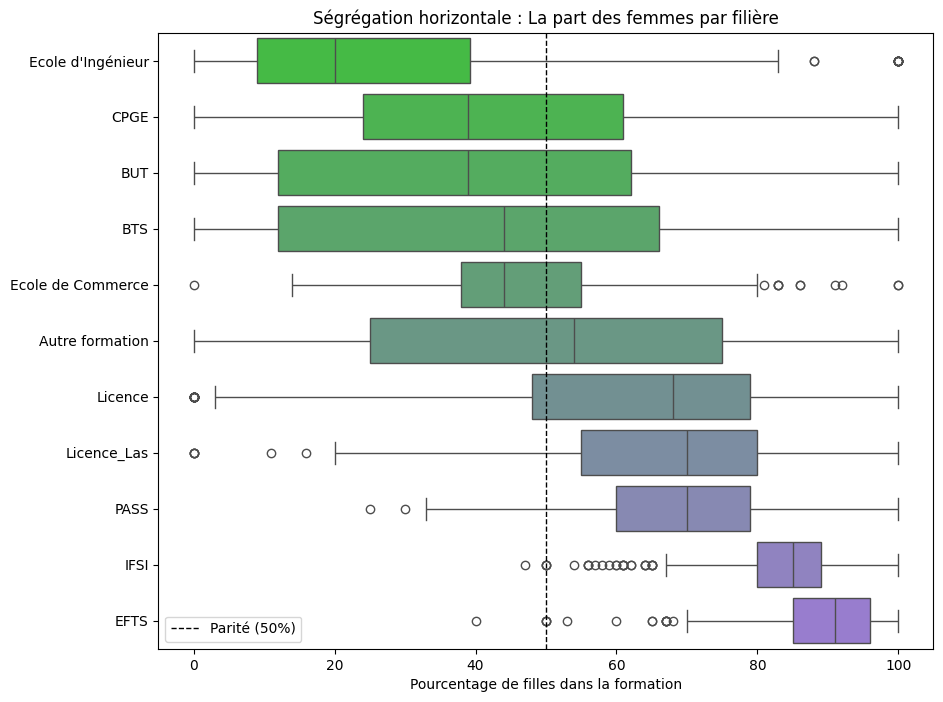

In [65]:
plt.figure(figsize=(10, 8))

# 1. Calcul de l'ordre (du plus masculin au plus féminin)
ordre = df.groupby("filiere_agr")["part_filles"].median().sort_values().index

nb_filieres = len(ordre)
degrade_genre = degrade(np.linspace(0,1, nb_filieres))

# 2. Création du Boxplot
sns.boxplot(
    data=df,
    x="part_filles",
    y="filiere_agr",
    order=ordre,
    palette=degrade_genre
)

# 3. Ajout de la ligne de parité
plt.axvline(x=50, color='black', linestyle='--', linewidth=1, label="Parité (50%)")

plt.title("Ségrégation horizontale : La part des femmes par filière")
plt.xlabel("Pourcentage de filles dans la formation")
plt.ylabel("")
plt.legend()
plt.show()

#En violet dominante féminine et en vers dominante masculine

Lorsqu'on regarde le détail par filière, il est possible de réaliser une typologie de ces filières. Les filières à dominante féminine sont majoritairement les formations du care qui sont quasi-exclusivement féminines. Les écoles de travail social (EFTS) avec une médiane de 90% de filles et les IFSI (médiane à 85%) sont particulièrement concernés. A l'inverse, les formations d'ingénieurs sont majoritairement masculines. Concernant les BTS, avec une moyenne de 41% de filles, ils semblent mixtes. Cependant l'écart interquartile est très important, suggérant qu'ils sont divisés entre les BTS industriels et technologiques (masculins) et les BTS tertiaires et de services (féminins).  

/tmp/ipykernel_80255/1029108672.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


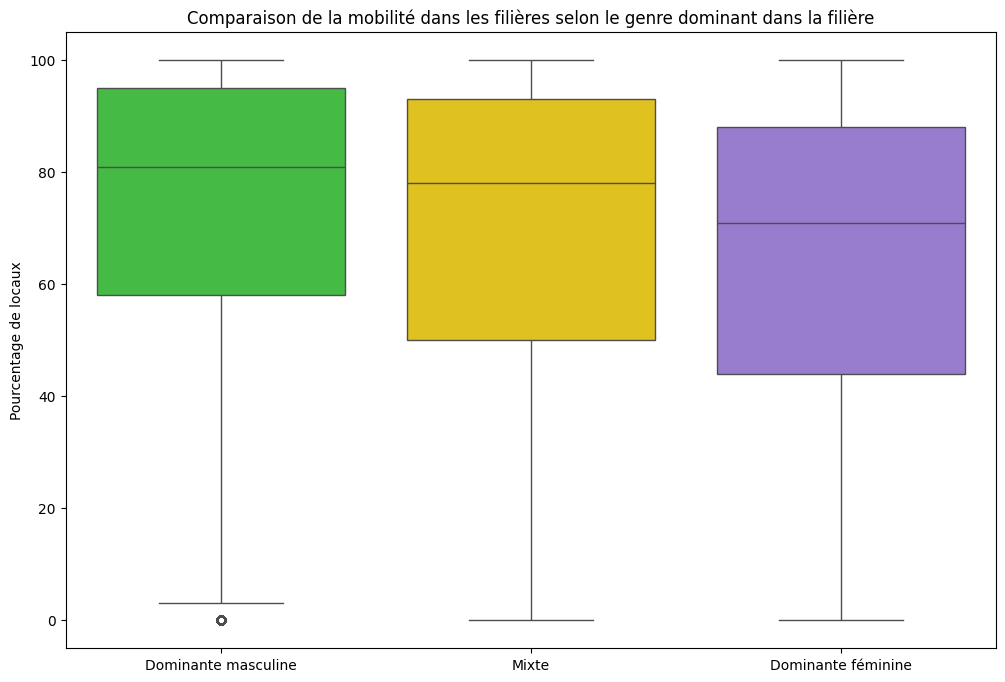

In [66]:
plt.figure(figsize=(12,8))

sns.boxplot(
    data=df,
    x="categorie_genre",
    y="part_bac_ac",
    palette=couleurs_genre,
)

plt.title("Comparaison de la mobilité dans les filières selon le genre dominant dans la filière")
plt.xlabel("")
plt.ylabel("Pourcentage de locaux")

plt.show()

Cette structure de l'offre se répercute directement sur l'ancrage territorial puisque ce graphique montre que les formations à dominante féminine sont plus mobiles que les formations masculines. L'écart, significatif, est de près de 10 points. En effet, la médiane des locaux est de 80% pour les formations masculines contre 70% pour les formations à dominante féminine. 

En effet, les formations masculines ont un réseau dense, porté par les BTS industriels présents dans de nombreux lycées ruraux et périurbains. Ainsi les garçons pourraient facilement se former proche de chez eux. A l'inverse, les filières féminines sont majoritairement universitaires ou rattachées à des centres hospitaliers. Elles se situent donc dans des pôles régionaux qui inciteraient les étudiantes à une mobilité, au moins intra-académique mais on perçoit ici seulement celle inter-académique, pour rejoindre la métropole la plus proche. 

<div style="background-color: #fff5f5; color: #000000; border-left: 6px solid #e74c3c; padding: 15px; border-radius: 4px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
    <h4 style="color: #c0392b; margin-top: 0;">Les filles bougent plus</h4>
    <p style="color: #000000;">
        Le genre agirait comme un déterminant indirect mais puissant de la mobilité :
        <ul style="color: #000000;">
            <li>Effet structurel : Les garçons s'orientent vers des filières techniques au maillage très fin (BTS de proximité), favorisant la sédentarité (80% de locaux). Alors que les filles s'orientent vers des filières universitaires ou de santé, concentrées dans les métropoles, imposant mécaniquement une plus grande mobilité (70% de locaux).</li>
        </ul>
        La géographie des formations "féminines" n'est pas la même que celle des formations "masculines".
    </p>
</div>

Ainsi, nous avons mis en évidence que le système de l'enseignement supérieur est relativement polarisé, que ce soit géographiquement, scolairement et socialement. Ces variables étant corrélées entre elles, nous effectuons une modélisation pour isoler les effets propres sur la décision de mobilité. 

<a id="modelisation"></a> 
## Modélisation

On cherche ce qui favorise la mobilité. Nous venons de voir plusieurs caractéristiques des formations qui peuvent expliquer pourquoi une formation recrute beaucoup d'étudiants issus d'autres académies, nous voulons désormais montrer que ces caractéristiques ont bien un effet significatif statistiquement parlant.

Pour cela, nous allons faire des régressions linéaires du taux d'entrants sur une ou plusieurs variables explicatives et déterminer grâce aux p-valeurs si ces variables ont un effet significatif ou pas.
On ne cherche pas à expliquer entièrement la valeur du taux d'entrants, c'est pourquoi on ne s'intéresse pas aux R^2 de ces régressions. Comme on travaille sur un sujet de sciences sociales, on s'attend à ce que ceux-ci soit assez faibles.
Les régressions que nous allons faire sont non causales, nous ne montrons donc que des corrélations et non pas des causalités, les données à notre disposition ne permettant pas d'estimer des effets causaux. 

<a id="effet_excellence"></a>
### L'effet de l'excellence

Nous avons vu grâce aux statistiques descriptives que les formations d'excellence, c'est-à-dire celles dont le taux d'étudiants ayant une mention très bien au bac ont généralement une part plus faible d'étudiants locaux.
Nous allons vérifier que cette différence est significative en régressant le taux d'entrants, c'est-à-dire le taux d'étudiants issus d'une autre académie, sur le taux de mention très bien au bac des étudiants ayant rejoint la formation.

Les coefficients de la régression sont :
constante : 22.393 
tb_eleves : 0.327 
Le R^2 obtenu est 0.049.
Les p-valeurs sont :
constante : 0.000e+00
tb_eleves : 1.275e-152


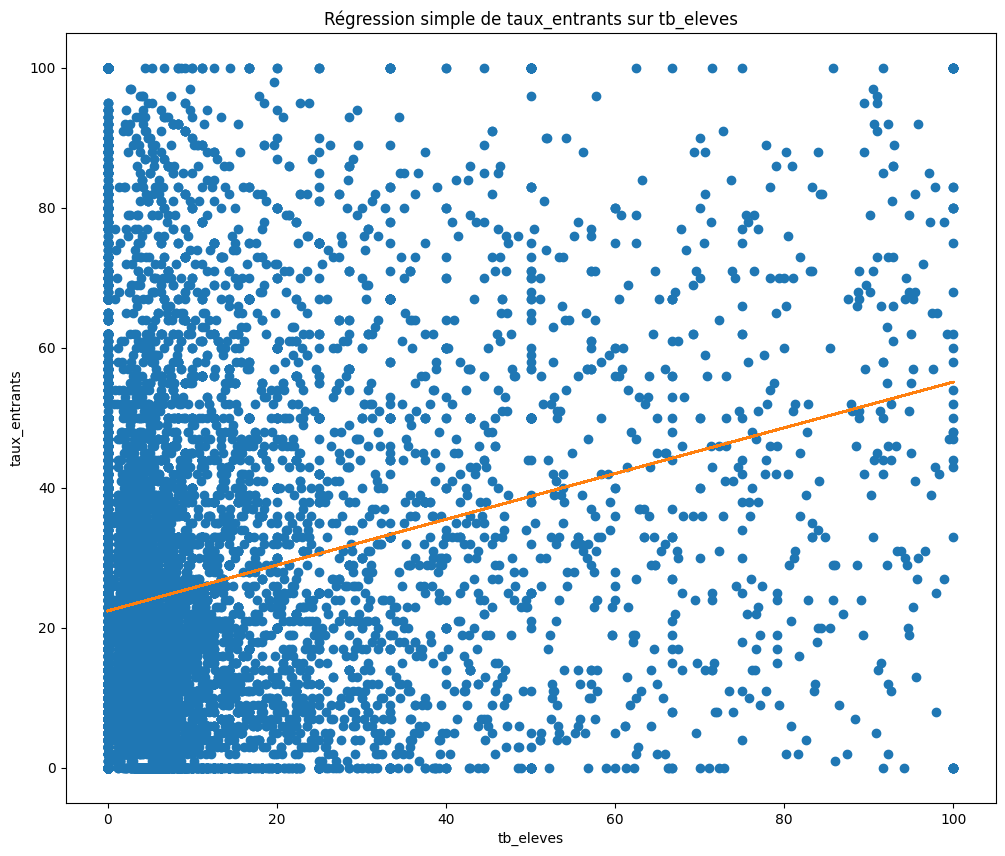

In [67]:
# importation des fonctions de régression
from function import regression, visualisation_reg

#df["nb_entrants"] = df["nb_admis"] - df["nb_admis_ac_pcv"]
#df["taux_entrants"] = df["nb_entrants"] / df["nb_admis"]*100
df["taux_entrants"] = 100 - df["part_bac_ac_pcv"]
#ajout d'une colonne constante
df = sm.add_constant(df)

regression(df, "tb_eleves","taux_entrants")
visualisation_reg(df,"tb_eleves","taux_entrants")

L e coefficient de tb_eleves est de 0,326. 
Il est statistiquement significatif à 1%, et positif, ce qui montre qu'une hausse de 1 point du taux d'élèves ayant une mention très bien est associé à une hausse de 0,326 points du taux d'étudiants issus d'une autre académie. 

Comme attendu, on obtient un R^2 très faible, ce qui signifie que notre mesure de l'excellence d'une formation est très peu explicative de son taux d'entrants.

<a id="effet_selec"></a>
### L'effet de la sélectivité

Avec les statistiques descriptives, nous avions constaté que les formations plus sélectives, avec un taux d'accès plus faible, tendent à avoir plus d'étudiants issus d'autres académies. Nous nous attendons donc à un coefficient négatif pour une régression du taux d'entrants sur le taux d'accès (plus le taux d'accès est élevé, ie moins la formation est sélective, moins il y a d'étudiants issus d'autres académies).


Les coefficients de la régression sont :
constante : 26.764 
taux_acces_clean : -0.012 
Le R^2 obtenu est 0.000.
Les p-valeurs sont :
constante : 0.000e+00
taux_acces_clean : 1.056e-01


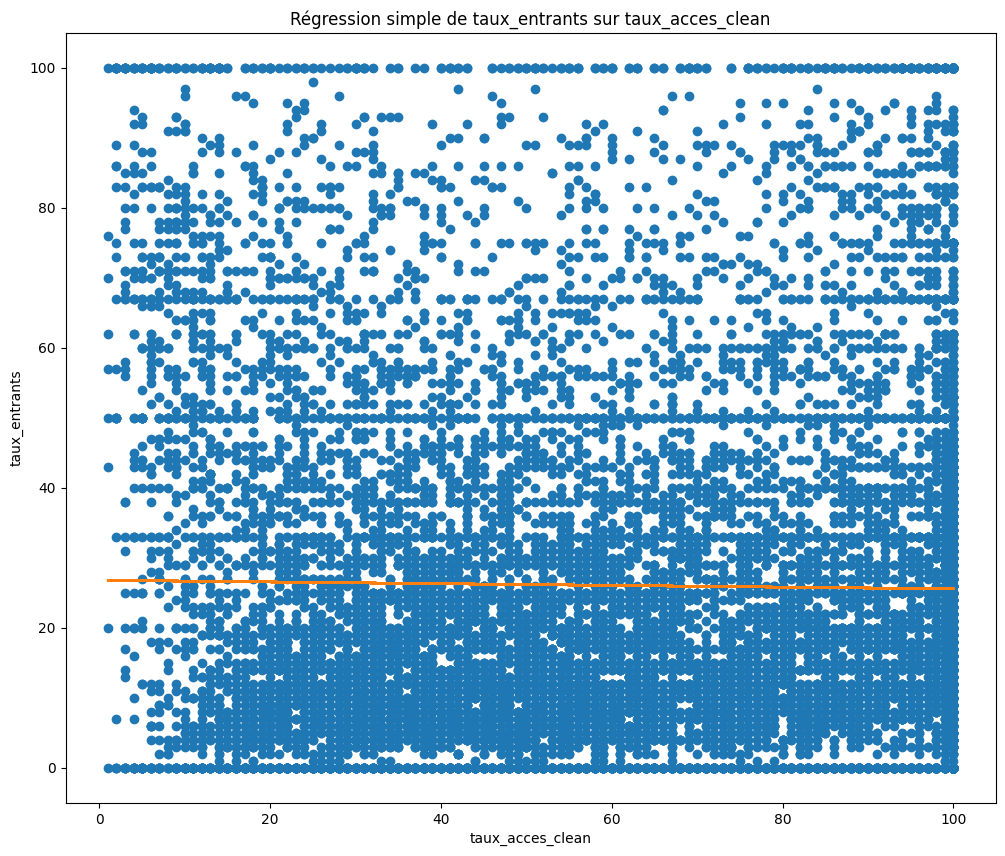

In [68]:
regression(df, "taux_acces_clean","taux_entrants")
visualisation_reg(df,"taux_acces_clean","taux_entrants")

On obtient comme attendu un coefficient négatif, de -0,011. Il n'est néanmoins pas significatif à 10 % puisque 0,16 > 0,1. La sélectivité d'une formation n'est donc pas une variable significative pour expliquer la part d'étudiants venant de loin qu'elle recrute, contrairement à son excellence par exemple.

<a id="effet_privé"></a>
### L'effet d'être une formation privée

On vérifie maintenant que le fait d'être une formation privée ou public a bien un effet significatif sur la part d'étudiants issus d'une autre académie recrutés par la formation. Pour rappel, l'étude des statistiques descriptives montrait que cette part était généralement plus élevé pour les formations privées. On s'attend donc à un coefficient positif.

In [69]:
# création d'une indicatrice de si la formation est privée ou non
df["1_privé"] = 0
df.loc[df["statut_public_prive"] == "Privé", "1_privé"] = 1

# régression
regression(df, "1_privé","taux_entrants")

Les coefficients de la régression sont :
constante : 25.273 
1_privé : 3.442 
Le R^2 obtenu est 0.003.
Les p-valeurs sont :
constante : 0.000e+00
1_privé : 1.193e-10


Notre régression confirme cette fois ce que les statistiques descriptives montraient : être une formation privée augmente en moyenne de 3,442 points le taux d'entrants de la formation, et cela de manière significative à 1% statistiquement parlant.

<a id="effet_genre"></a>
### L'effet du genre

Nous allons maintenant vérifier la significativité de la dernière variable étudiée dans la partie de statistiques descriptives comme pouvant expliquer la variation du taux d'étudiants issus d'une autre académie pour une formation : le genre des élèves de cette formation.

Nous avions observé que les filières les plus féminisées avaient un taux d'entrants généralement plus élevé, ce qui suggérait une mobilité plus importante des filles pour leurs études supérieures. Nous nous attendons donc à un coefficient positif pour la régression du taux d'entrants sur la part de filles.

Les coefficients de la régression sont :
constante : 20.736 
part_filles : 0.104 
Le R^2 obtenu est 0.014.
Les p-valeurs sont :
constante : 0.000e+00
part_filles : 2.243e-44


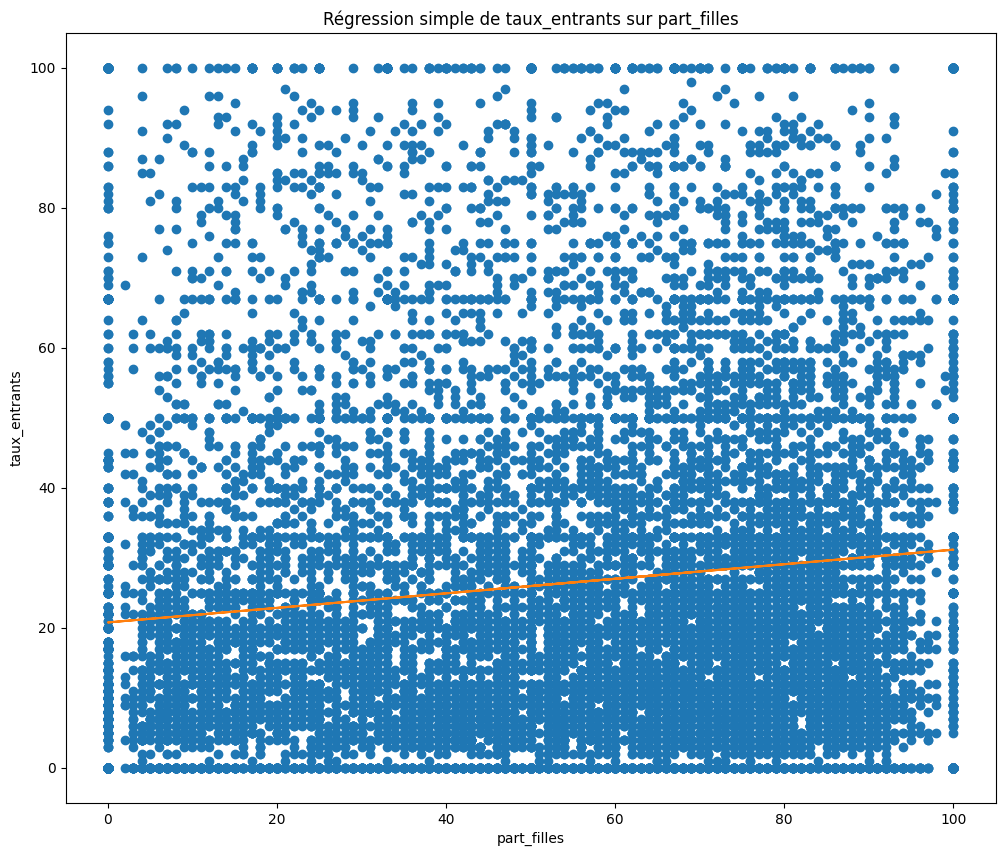

In [70]:
regression(df, "part_filles","taux_entrants")
visualisation_reg(df,"part_filles","taux_entrants")

Comme attendu, on obtient bien un coefficient positif, de 0,104. Ce coefficient est encore une fois significatif à 1%.

<a id="effet_pop"></a>
### L'effet du lieu où se situe la formation

On a jusque là cherché à expliquer le fait qu'une formation attire des étudiants de loin par des caractéristiques qui lui sont propres, comme sa sélectivité ou le niveau de la formation proposée. Cependant, d'autres raisons peuvent pousser les étudiants à rejoindre une formation située loin de chez eux, qui sont liées à l'endroit où se trouve cette formation. On peut, par exemple, penser qu'un des critères pour les étudiants lorsqu'ils choisissent une formation est le fait qu'elle soit située dans un endroit propice à une vie étudiante de qualité. A l'inverse, on peut penser qu'une formation située dans un endroit où il n'y a pas ou peu de logements pour les étudiants, avec peu d'activités à faire autour, attirera moins les étudiants.

On cherche donc une variable qui indiquerait l'attractivité pour un étudiant du lieu où se situe une formation. C'est évidemment difficile de trouver une telle variable qui résumerait tout cela, d'autant plus qu'il y a une part de subjectivité dans les critères choisis pour déterminer l'attractivité d'un lieu. Néanmoins, en première approche, on peut penser que la population de la zone où se situe la formation constitue une bonne approximation. En effet, on peut raisonnablement estimer que la population d'une aire urbaine est corrélée au nombre de logements accessibles à des étudiants qui s'y trouve ainsi qu'au nombre de commerces et de lieux de divertissement *(pas sûre de la formulation, mais en gros les bars, cinémas, ... les endroits où on peut s'occuper)* disponibles.

Idéalement, on voudrait donc faire une régression du taux d'étudiants issus d'une autre académie rejoignant une formation sur la population de la commune ou de l'aire urbaine dans laquelle elle se trouve. Nous sommes cependant confrontés à une limitation de notre base de données, dans laquelle est indiquée la commune où se trouve chaque formation, mais sans son code géographique ou même code postal associé qui permettrait de faire une jointure avec une base de données contenant les populations de chaque commune de France. Avec seulement le nom, qui peut être écrit de manière différente dans les deux bases et ne pas être unique, dans le cas où deux villes portent le même nom, la qualité des résultats obtenus serait difficile à évaluer. 
Nous faisons donc le choix de faire une régression sur la population du département, pour lequel nous disposons d'un identifiant unique à chaque département.

Nous commençons par créer un dataframe contenant les populations totales de chaque département en 2024 à partir de l'API de l'Insee :


In [71]:
# récupération des données 
url_pop_dep = "https://api.insee.fr/melodi/data/DS_ESTIMATION_POPULATION?TIME_PERIOD=2024&SEX=_T&AGE=_T&EP_MEASURE=POP&GEO=DEP"
req_api = requests.get(url_pop_dep).json()
clean_req = req_api.get('observations') # on obtient une liste de dictionnaires
                                        # un dictionnaire = une observation

# transformation en dataframe
from function import create_df_pop
df_pop = create_df_pop(clean_req)

df_pop.head(2)

,Niveau géographique,Population
0,2023-DEP-29,933628.0
1,2023-DEP-23,114600.0


Dans le dataframe qu'on obtient, le numéro de département n'est pas sous la bonne forme, nous le transformons donc en valeur numérique : 

In [72]:
from function import conversion
df_pop['Département'] = df_pop['Niveau géographique'].apply(conversion)

Il faut aussi modifier notre dataframe contenant les données Parcoursup pour supprimer les formations situées à l'étranger et rajouter un numéro de département pour les formations de la Haute-Corse et de la Corse-du-Sud pour lesquelles aucun numéro de département n'est indiqué :

In [73]:
# on supprime les formations situées à l'étranger :
clean_df = df.drop(df[df["academie"] == "Etranger"].index, inplace=False)

# pour la Corse, code_dep est vide donc on fixe une valeur arbitrairement en utilisant des "float" dans un soucis de cohérence:
clean_df.loc[clean_df["dep"] == "Haute-Corse", "code_dep"] = 100
clean_df.loc[clean_df["dep"] == "Corse-du-Sud", "code_dep"] = 101

On peut maintenant joindre les deux bases et faire notre régression. 

Néanmoins, la population est une variable qui peut prendre des valeurs très élevées dans certains départements, notamment en Ile-de-France, et l'on peut penser qu'à partir d'un certain stade, l'attractivité d'un endroit n'augmente plus autant avec sa population. On va donc régresser non pas directement sur la population du département de la formation mais sur son logarithme, pour réduire l'impact des valeurs trop élevées sur nos résultats.

Les coefficients de la régression sont :
constante : 53.514 
log_pop : -1.994 
Le R^2 obtenu est 0.003.
Les p-valeurs sont :
constante : 8.885e-34
log_pop : 4.538e-10


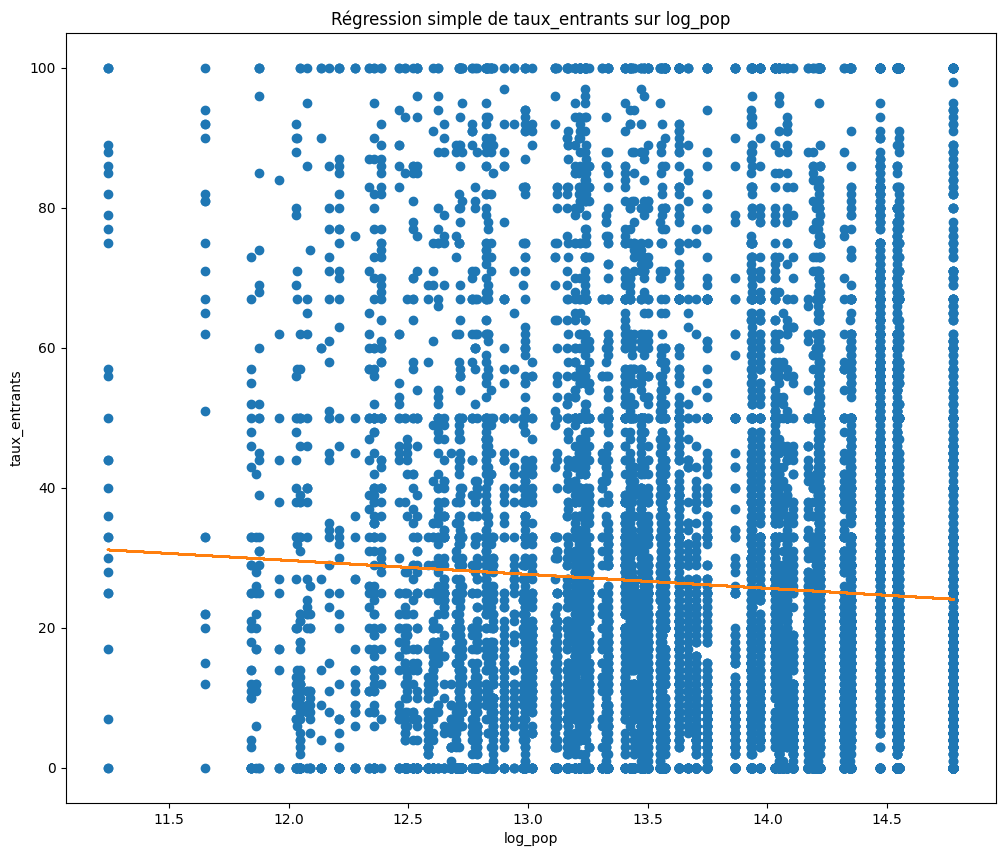

In [74]:
# jointure
merged_df = clean_df.merge(df_pop, left_on="code_dep", right_on="Département", how='left')

# création de la variable du logarithme de la population 
merged_df["log_pop"] = merged_df["Population"].apply(np.log)

# régression
regression(merged_df, "log_pop","taux_entrants")
visualisation_reg(merged_df,"log_pop","taux_entrants")

Contrairement à ce qu'on attendait, on obtient un coefficient négatif, de -1,994, qui est significatif à 1%. Le fait que ce résultat ne corresponde pas à ce qu'on attendait peut s'expliquer de plusieurs manières :
- comme on l'a dit au début, on régresse sur la population du département où se trouve la formation et non pas sur la population de la commune ou de l'aire urbaine qui aurait été plus adapté
- on utilise ici la population comme un proxy de l'attractivité pour un étudiant de l'endroit où se situe la formation, et on a expliqué ce qui justifiait ce choix, mais on ne sait pas si empiriquement c'est vraiment un bon proxy

Au vu de nos résultats, nous ne pouvons donc pas vérifier que l'attractivité du lieu où se situe la formation a bien un effet sur la part d'étudiants issus d'autres académies qu'elle recrute.

<a id="conclu"></a>
## Conclusion

Ce projet avait pour objectif de comprendre les déterminants de la mobilité étudiante lors de l'entrée dans l'enseignement supérieur. En analysant des données Parcoursup, nous avons cherché à déterminer si la mobilité est relève d'un choix stratégique ou d'une contrainte structurelle.

Les analyses descriptives ont dressé le paysage d'une offre de formation hiérarchisée et inégalement répartie sur le territoire. La mobilité apparaît d'abord comme une réponse à ces inégalités territoriales. Le niveau scolaire et les déterminants sociaux, tels que le genre, semblent également façonner les trajectoires. Enfin, des caractéristiques propres à l'offre, comme le statut de l'établissement ou sa sélectivité, jouent vraisemblablement un rôle.

L'approche économétrique a permis d'isoler les facteurs déterminants, *ceteris paribus*. Elle confirme que le genre et le niveau académique sont des moteurs de la mobilité, tout comme le statut privé de l'établissement qui attire davantage d'étudiants extérieurs. *A contrario*, l'effet de la sélectivité s'est révélée non significatif dans noter modèle, suggérant que ce sont davantage d'autres caractéristiques de la formation (filière, prestige) qui jouent. 

La modélisation nous a également mis en lumière certaines limites de notre analyse, notamment l'importance de l'échelle d'analyse. En effet, le résultat, contre-intuitif, concernant l'impact de la population départementale sur l'attractivité, souligne que l'échelle départementale était vraisemblablement trop agrégée pour capter la dynamique des pôles universitaires. De plus, notre définition de la mobilité comme un changement d'académie, masque les mobilités intra-académiques, qui restent pourtant importantes. 

Une piste d'amélioration consisterait à utiliser des données plus précises, par exemple le lycée d'origine, pour analyser la mobilité en fonction de la distance réelle et non plus des frontières administratives. 
